# Data Augmentation - Conditional Wasserstein GANs - GP

### Dataset: Human Dataset

This notebook presents the CWGAN-GP model to generate treated Intensity Data from the experimental human dataset but to test the GAN sample networks in an imbalanced dataset to suplement the class with the least samples with extra ones.

Notebook Organization:
- Read the dataset and split it into the imbalanced set and test set
- Setup the CWGAN-GP model and train the model with human intensity data
- Generate artificial samples in an artificial dataset and compare them to the experimental data
- Compare supervised statistical analysis performance on the original dataset, imbalanced dataset, and compensated dataset

#### Needed Imports

In [1]:
from pathlib import Path

# json for persistence
import json
from time import perf_counter

import numpy as np
import pandas as pd

import scipy.spatial.distance as dist
import scipy.cluster.hierarchy as hier
import scipy.stats as stats

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
from matplotlib import ticker

import seaborn as sns
from collections import namedtuple, Counter

from tqdm import tqdm
from IPython import display as ipythondisplay

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import sklearn.ensemble as skensemble
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

import tensorflow as tf
import os
from keras import backend

# Metabolinks package
import metabolinks as mtl
import metabolinks.transformations as transf

# Python files in the repository
import multianalysis as ma
from elips import plot_confidence_ellipse
import gan_evaluation_metrics as gem
import linear_augmentation_functions as laf

In [2]:
%matplotlib inline

Reading the data to be analysed and augmented

#### Loading Human dataset

Note: Require 'ST001082_AN001766_HD.xlsx' file.

In [4]:
# Reading the dataset, this dataset has two copies of the samples.The 2nd copy is equal to the 1st multiplied by a constant
# unique to each sample.
human_datamatrix_base = pd.read_excel('ST001082_AN001766_HD.xlsx')

In [5]:
human_datamatrix = human_datamatrix_base.iloc[:-1, :-4] # Just select the rows corresponding to the dataset
mz_list = human_datamatrix_base.iloc[:-1, -4] # Select column with list of m/z values

human_datamatrix = human_datamatrix.set_index(human_datamatrix.columns[0]) # Set index as the metabolites name
human_datamatrix = human_datamatrix.replace({0:np.nan}) # Replacing 0 values as missing values

human_datamatrix

,2_Pooled_Sample_1,2_Pooled_Sample_1_2,P2_2,P2_3,P2_4,Psp_1,Psp_2,Psp_3,Psp_4,Psp_5,...,S67_3.1,S70_1.1,S70_2.1,S70_3.1,S72_1.1,S72_2.1,S72_3.1,S77_1.1,S77_2.1,S77_3.1
metabolite_name,,,,,,,,,,,,,,,,,,,,,
Factors,Sample Type:Pooled,Sample Type:Pooled,Sample Type:Pooled,Sample Type:Pooled,Sample Type:Pooled,Sample Type:Pooled,Sample Type:Pooled,Sample Type:Pooled,Sample Type:Pooled,Sample Type:Pooled,...,Sample Type:No Recurrence,Sample Type:No Recurrence,Sample Type:No Recurrence,Sample Type:No Recurrence,Sample Type:No Recurrence,Sample Type:No Recurrence,Sample Type:No Recurrence,Sample Type:No Recurrence,Sample Type:No Recurrence,Sample Type:No Recurrence
95.06024579_7.857483333,2544.256904,2174.683995,2349.405324,2142.906787,2633.130278,2510.239989,3619.82127,2217.770816,2894.966994,20587.0328,...,4121.029059,3834.23691,4090.323428,3830.272712,3705.545567,3954.147516,3740.035077,3837.308267,4164.971893,4155.190276
71.06031304_0.064166667,153.7382834,2972.450721,951.0420238,2861.700714,3339.380877,299.8124672,783.1155979,3034.247021,3511.131943,NaN,...,8012.257751,853.7856117,6297.664545,7257.02521,845.5966076,6130.01575,7499.72554,796.3862056,5999.547509,7583.908921
71.06031992_9.984466667,292.2381888,1598.405492,638.9111168,1659.297423,1855.933656,382.0675008,948.3162562,1707.100565,1981.102653,62862.60997,...,4440.820011,662.2607137,3347.680062,4147.143726,694.8464783,3388.086581,4194.416655,650.7198089,3381.510189,4134.43322
126.1023924_4.038416667,347.8838312,125.0657553,260.8042864,119.6837125,NaN,803.1992227,NaN,126.2802051,0.001242692,582.9410185,...,322.3904954,4488.12769,3755.93028,1616.363518,1806.669855,1365.45848,495.4602756,1993.623747,1663.073748,1059.509693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
588.4147684_2.0983,12264.30083,1935.998098,2697.901871,1761.340872,369.0957455,12243.27287,574.4747938,221.0599403,11.37397281,NaN,...,NaN,6225.892205,NaN,NaN,8491.983882,NaN,NaN,9425.946784,358.953733,NaN
177.1270579_2.0983,4477.875444,317.9191822,2573.952315,69.97337036,NaN,5703.699795,NaN,477.9239747,960.7144488,NaN,...,5104.451502,NaN,248.6690155,4012.400432,189.415007,1938.392231,5601.351328,NaN,25.42248559,4329.675354
374.2064688_2.0983,7056.085863,112.7816239,4444.488636,NaN,NaN,6690.765635,NaN,462.1335736,572.3140362,NaN,...,6158.786604,NaN,NaN,3297.509597,NaN,NaN,2256.379266,NaN,NaN,7587.036926


In [6]:
# Select one of the two copies of samples in the dataset by removing the samples ending with '.1'
human_datamatrix = human_datamatrix[[i for i in human_datamatrix.columns if not i.endswith('.1')]]

human_datamatrix = human_datamatrix.T # Transpose the dataset

In [7]:
# Current sample labels. Sample will consist of 'Sample Type:No Recurrence' and 'Sample Type:Recurrence'
original_labels = list(human_datamatrix['Factors'])
set(original_labels)

{'Sample Type:Blank',
 'Sample Type:No Recurrence',
 'Sample Type:Pooled',
 'Sample Type:Recurrence'}

In [8]:
# How many 'No Recurrence' samples in the dataset
original_labels.count('Sample Type:No Recurrence')

135

### Blank Treatment

- If blank_treatment = True:

An average of the blanks will be subtracted to the remaining dataset. Missing values in the blanks were replaced by 0 to calculate the average of the blanks. Negative values that arise in the dataset from subtracting the blanks will be coded as 0/missing values in the dataset.

- If blank_treatment = False:

Blank samples are removed and not accounted for. 

In [9]:
blank_treatment = True
#blank_treatment = False

In [10]:
if blank_treatment:
    blanks = human_datamatrix[human_datamatrix['Factors'] == 'Sample Type:Blank'].iloc[:,1:] # Select blank samples
    blanks = blanks.replace({np.nan:0}) 
    blanks = blanks.astype(float) # Get blank samples with floats (needed since datamatrix has strings)
    blanks_average = blanks.mean() # Average of the blanks
    blanks_average

In [11]:
# Selecting the samples belonging to either the 'No Recurrence' or 'Recurrence' 
selection = []
for i in human_datamatrix.loc[:, 'Factors']:
    if i in ['Sample Type:No Recurrence', 'Sample Type:Recurrence']:
        selection.append(True)
    else:
        selection.append(False)

In [12]:
human_datamatrix = human_datamatrix[selection]
# Creating the list of 'targets' (labels of samples) of the dataset with the 'No Recurrence' and 'Recurrence' classes 
original_labels = []
for i in list(human_datamatrix.iloc[:,0]):
    if i == 'Sample Type:No Recurrence':
        original_labels.append('No Recurrence')
    else:
        original_labels.append('Recurrence')

In [13]:
human_datamatrix = human_datamatrix.iloc[:,1:]
human_datamatrix

metabolite_name,95.06024579_7.857483333,71.06031304_0.064166667,71.06031992_9.984466667,126.1023924_4.038416667,121.0717995_1.358816667,105.0697004_2.574533333,83.06023778_3.971433333,85.02828928_2.7925,85.0282975_2.440233333,88.05051567_0.095966667,...,370.0920791_2.0983,468.1567372_2.0983,727.5149425_2.0983,497.1417674_2.0983,400.1388094_2.0983,588.4147684_2.0983,177.1270579_2.0983,374.2064688_2.0983,211.0531259_2.0983,206.0808246_2.0983
S10_1,5839.689646,2421.207099,1702.403305,1732.645968,11202.3156,13.77354446,15969.09873,11122.92882,76033.09098,15559.66213,...,549.5061406,1788.00406,237.4614192,3065.766426,170.0414581,1347.054595,479.0767276,NaN,NaN,41.58211389
S10_2,4925.936713,6760.239327,3927.481184,876.2460627,16464.75568,144.7380541,11235.281,17168.89308,50955.48348,17634.72493,...,2354.284435,428.9492324,6.856593556,126.8752621,6686.085356,NaN,5663.904982,11572.89831,1720.669345,3969.969384
S10_3,5530.737291,11234.04531,6138.510579,302.5141329,24441.42344,196.744245,6281.973729,23329.82436,38668.17711,17924.91677,...,1187.542997,8.16828659,4.535420845,NaN,6985.148407,5.695198924,5001.930045,9622.04692,1835.400914,3534.540622
S15_1,4345.962212,1647.020375,1087.357218,2044.425809,4820.244022,8.539063852,10824.9497,2858.654761,48787.91979,12293.8573,...,NaN,2378.896459,578.7754145,NaN,155.6123097,2164.462213,936.4502838,NaN,NaN,66.89873449
S15_2,4135.848719,7164.394072,3594.221384,1396.827349,6507.869956,56.61978795,8963.260007,6670.576787,49360.26082,23406.46182,...,NaN,437.5625196,11.89033556,1.767176652,1485.254178,73.86922602,1952.194542,NaN,NaN,282.3818514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S72_2,4042.390453,6266.816562,3463.69699,1395.930804,10517.7526,97.700184,17988.63512,4597.778125,24216.15305,23606.86636,...,7049.366359,NaN,0.910517997,1273.048903,3601.773523,NaN,1981.650461,NaN,3938.848802,144.146236
S72_3,3860.581052,7741.451008,4329.607912,511.4295756,15224.61293,594.5983793,9768.49416,7663.919663,17897.95381,12847.39403,...,5875.548618,NaN,0.355728465,NaN,15046.7641,NaN,5781.889838,2329.105172,4675.475887,1257.137318
S77_1,4741.732906,984.0884324,804.0895638,2463.50584,5199.447492,8.686503713,10287.69548,2550.038217,36939.60819,17136.32435,...,NaN,2098.000087,3969.01007,NaN,81.4497374,11647.5714,NaN,NaN,0.896501216,239.696676
S77_2,4153.731532,5983.356024,3372.384222,1658.585471,7551.248853,26.64915706,8092.077171,4522.858963,32505.31818,23193.57557,...,NaN,349.8420486,782.9663571,NaN,486.1349482,357.9849943,25.35387578,NaN,NaN,351.8411172


In [14]:
human_datamatrix = human_datamatrix.astype(float) # Passing the values from strings to floats.

In [15]:
if blank_treatment:
    human_datamatrix = human_datamatrix.replace({np.nan:0}) - blanks_average
    human_datamatrix[human_datamatrix<0] = 0
    human_datamatrix = human_datamatrix.replace({0:np.nan})

'Neutralization' of the _m/z_ values by subtracting the mass of a proton to the _m/z_ peaks.

4 peaks (2 pairs) with different retention time have the exact same _m/z_ values. These 2 pairs of peaks wil be treated as only 2 different peaks (instead of four).

In [16]:
# Atomic masses - https://ciaaw.org/atomic-masses.htm
#Isotopic abundances-https://ciaaw.org/isotopic-abundances.htm/https://www.degruyter.com/view/journals/pac/88/3/article-p293.xml
# Isotopic abundances from Pure Appl. Chem. 2016; 88(3): 293–306,
# Isotopic compositions of the elements 2013 (IUPAC Technical Report), doi: 10.1515/pac-2015-0503

chemdict = {'H':(1.0078250322, 0.999844),
            'C':(12.000000000, 0.988922),
            'N':(14.003074004, 0.996337),
            'O':(15.994914619, 0.9976206),
            'Na':(22.98976928, 1.0),
            'P':(30.973761998, 1.0),
            'S':(31.972071174, 0.9504074),
            'Cl':(34.9688527, 0.757647),
            'F':(18.998403163, 1.0),
            'C13':(13.003354835, 0.011078) # Carbon 13 isotope
           } 

# electron mass from NIST http://physics.nist.gov/cgi-bin/cuu/Value?meu|search_for=electron+mass
electron_mass = 0.000548579909065

In [17]:
mz_list = mz_list[1:] - chemdict['H'][0] + electron_mass
counts = human_datamatrix.count(axis=0)
final_mz_list = list(mz_list[list(counts >= 2)])
final_mz_list = set(final_mz_list)

Data Pre-treatment of the dataset

In [18]:
human_datamatrix = transf.keep_atleast(human_datamatrix, minimum=2) # Keep features that appear in at least two samples
human_datamatrix

metabolite_name,71.06031304_0.064166667,71.06031992_9.984466667,126.1023924_4.038416667,121.0717995_1.358816667,105.0697004_2.574533333,83.06023778_3.971433333,85.02828928_2.7925,85.0282975_2.440233333,103.0539927_2.632416667,117.0695881_0.77655,...,370.0920791_2.0983,468.1567372_2.0983,727.5149425_2.0983,497.1417674_2.0983,400.1388094_2.0983,588.4147684_2.0983,177.1270579_2.0983,374.2064688_2.0983,211.0531259_2.0983,206.0808246_2.0983
S10_1,NaN,NaN,767.728678,7664.437238,NaN,11885.760381,11034.772529,71411.834905,NaN,272.371357,...,549.506141,1788.004060,237.461419,3065.766426,170.041458,1347.054595,474.490232,NaN,NaN,41.582114
S10_2,NaN,NaN,NaN,12926.877318,128.638686,7151.942651,17080.736789,46334.227405,881.713011,470.898334,...,2354.284435,428.949232,6.856594,126.875262,6686.085356,NaN,5659.318486,11569.699041,1720.669345,3969.969384
S10_3,1546.96215,0.29663,NaN,20903.545078,180.644877,2198.635380,23241.668069,34046.921035,1439.412175,101.298661,...,1187.542997,8.168287,4.535421,NaN,6985.148407,5.695199,4997.343549,9618.847651,1835.400914,3534.540622
S15_1,NaN,NaN,1079.508519,1282.365660,NaN,6741.611351,2770.498470,44166.663715,155.791159,NaN,...,NaN,2378.896459,578.775415,NaN,155.612310,2164.462213,931.863788,NaN,NaN,66.898734
S15_2,NaN,NaN,431.910059,2969.991594,40.520419,4879.921658,6582.420496,44739.004745,168.413145,NaN,...,NaN,437.562520,11.890336,1.767177,1485.254178,73.869226,1947.608046,NaN,NaN,282.381851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S72_2,NaN,NaN,431.013514,6979.874238,81.600816,13905.296771,4509.621834,19594.896975,33.998957,NaN,...,7049.366359,NaN,0.910518,1273.048903,3601.773523,NaN,1977.063965,NaN,3938.848802,144.146236
S72_3,NaN,NaN,NaN,11686.734568,578.499011,5685.155811,7575.763372,13276.697735,901.326825,NaN,...,5875.548618,NaN,0.355728,NaN,15046.764100,NaN,5777.303342,2325.905903,4675.475887,1257.137318
S77_1,NaN,NaN,1498.588550,1661.569130,NaN,6204.357131,2461.881926,32318.352115,NaN,NaN,...,NaN,2098.000087,3969.010070,NaN,81.449737,11647.571400,NaN,NaN,0.896501,239.696676
S77_2,NaN,NaN,693.668181,4013.370491,10.549789,4008.738822,4434.702672,27884.062105,164.837670,NaN,...,NaN,349.842049,782.966357,NaN,486.134948,357.984994,20.767380,NaN,NaN,351.841117


In [19]:
# For missing value imputation based on constants relative to the minimum of each feature instead of the full dataset
def fillna_frac_feat_min(df, fraction=0.2):
    """Set NaN to a fraction of the minimum value in each column of the DataFrame."""

    minimum = df.min(axis=0) * fraction
    return df.fillna(minimum)

In [20]:
human_datamatrix_I = fillna_frac_feat_min(human_datamatrix, fraction=0.2)

In [21]:
hd_matrix = human_datamatrix_I.copy()
hd_datamatrix_N = transf.normalize_PQN(hd_matrix, ref_sample='mean')
hd_datamatrix_treated = transf.pareto_scale(transf.glog(hd_datamatrix_N, lamb=None))

**Building the imbalanced dataset**

Randomly choose 20 Recurrence of samples (out of 114) and 100 (out of 135) No Recurrence samples, making an imbalanced dataset with lack of Recurrence samples.

The remaining samples (94 Recurrence and 35 no Recurrence) will make up the test set.

In [22]:
rng = np.random.default_rng(7519)

# Select the samples which will be in the imbalanced and in the test set
permutation_rec = list(rng.permutation(114))
permutation_norec = list(rng.permutation(125) + 114)

train_idxs = permutation_rec[:20] + permutation_norec[:100]
test_idxs = permutation_rec[20:] + permutation_norec[100:]

In [23]:
# Create the imbalanced and test set
human_datamatrix = human_datamatrix_I.iloc[train_idxs]
hd_labels = list(np.array(original_labels)[train_idxs])

test_datamatrix = human_datamatrix_I.iloc[test_idxs]
test_data_labels = list(np.array(original_labels)[test_idxs])

In [24]:
# Data pretreatment of the imbalanced and test dataset
human_datamatrix_N = transf.normalize_PQN(human_datamatrix, ref_sample='mean')
human_datamatrix_treated = transf.pareto_scale(transf.glog(human_datamatrix_N, lamb=None))

test_datamatrix_N = transf.normalize_PQN(test_datamatrix, ref_sample='mean')
test_datamatrix_treated = transf.pareto_scale(transf.glog(test_datamatrix_N, lamb=None))

Linear Augmentation / Interpolation of the experimental data and corresponding sample labels/classes to use as training data for the GAN network.

Used the data after missing value imputation and before other pre-treatments.

Due to HD size, this takes a long time (in a way, it would not be needed due to the high number of samples), but we do it as an example and coherency with the remaining datasets.

In [25]:
GENERATE = True

In [26]:
# Only generation of samples based on the imbalanced dataset
if GENERATE:
    start = perf_counter()
    data, lbls = laf.artificial_dataset_generator(human_datamatrix, labels=hd_labels,
                                            max_new_samples_per_label=512, binary=False, rnd=list(np.linspace(0.2,0.8,3)), 
                                            binary_rnd_state=None, rnd_state=None)
    end = perf_counter()
    print(f'Simple augmentation of data done! took {(end - start):.3f} s')

In [27]:
# Then pre-treatment of the newly generated data
if GENERATE:
    data_N = transf.normalize_PQN(data, ref_sample='mean')
    data_treated = transf.pareto_scale(transf.glog(data_N, lamb=None))

In [28]:
# Store the generated data as to not need to make them again
if GENERATE:
    # Store Linear Augmented Data
    data_treated.to_csv('store_data/HD_generated_data_NGP_imbalanced.csv')

    # Store labels/classes corresponding to each generated sample
    with open('store_data/HD_data_NGP_lbls_imbalanced.txt', 'w') as a:
        for item in lbls:
            a.write("{}\n".format(item))
        #print(lbls, file=a)

In [29]:
# Read back the generated GAN data
if not GENERATE:
    data_treated = pd.read_csv('store_data/HD_generated_data_NGP_imbalanced.csv')
    data_treated = data_treated.set_index(data_treated.columns[0])
    data_treated

    with open('store_data/HD_data_NGP_lbls_imbalanced.txt') as a:
        lbls = a.read().split('\n')[:-1]

### Obtaining Inputs for GAN model

In [30]:
# Get distribution of intensity values of the dataset
hist = np.histogram(human_datamatrix_treated.values.flatten(), bins=100)
input_realdata_dist = stats.rv_histogram(hist)

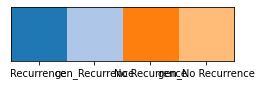

In [31]:
colours2 = sns.color_palette('tab20', 4)[:5]

ordered_labels_test = ('Recurrence','gen_Recurrence','No Recurrence','gen_No Recurrence')
label_colors_test = {lbl: c for lbl, c in zip(ordered_labels_test, colours2)}
ordered_labels = ['Recurrence', 'No Recurrence']

sns.palplot(label_colors_test.values())
new_ticks_test = plt.xticks(range(len(ordered_labels_test)), ordered_labels_test)

## Conditional Wasserstein GAN - GP model

This model construction was made by joining WGAN-GP models with Conditional GAN models. WGAN-GP models were originally made according to / originally based in https://keras.io/examples/generative/wgan_gp/#wasserstein-gan-wgan-with-gradient-penalty-gp and Conditional GAN models - https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/ (generator and discriminator model) and https://keras.io/examples/generative/conditional_gan/ without using OOP (loss functions and training/training steps).

In [32]:
# Import needed functions from GAN_functions
#from GAN_functions import wasserstein_loss
from GAN_functions import gradient_penalty_cwgan
from GAN_functions import critic_loss_wgan
from GAN_functions import generator_loss_wgan

In [33]:
batch_size = 32

In [34]:
def generator_model(len_input, len_output, n_hidden_nodes, n_labels):
    "Make the generator model of CWGAN-GP."

    data_input = tf.keras.Input(shape=(len_input,), name='data') # Take intensity input
    label_input = tf.keras.Input(shape=(1,), name='label') # Take Label Input

    # Treat label input to concatenate to intensity data after
    label_m = tf.keras.layers.Embedding(n_labels, 30, input_length=1)(label_input)
    label_m = tf.keras.layers.Dense(256, activation='linear', use_bias=True)(label_m)
    #label_m = tf.keras.layers.Reshape((len_input,1,))(label_m)
    label_m2 = tf.keras.layers.Reshape((256,))(label_m)

    joined_data = tf.keras.layers.Concatenate()([data_input, label_m2]) # Concatenate intensity and label data
    # Hidden Dense Layer and Normalization
    joined_data = tf.keras.layers.Dense(n_hidden_nodes, activation=tf.nn.leaky_relu, use_bias=True)(joined_data)
    joined_data = tf.keras.layers.Dense(256, activation=tf.nn.leaky_relu, use_bias=True)(joined_data)
    joined_data = tf.keras.layers.BatchNormalization()(joined_data)

    # Output - number of features of sample to make
    output = tf.keras.layers.Dense(len_output, activation='linear', use_bias=True)(joined_data)
    
    generator = tf.keras.Model(inputs=[data_input, label_input], outputs=output)
    
    return generator

def critic_model(len_input, n_hidden_nodes, n_labels):
    "Make the critic model of CWGAN-GP."
    
    label_input = tf.keras.Input(shape=(1,)) # Take intensity input
    data_input = tf.keras.Input(shape=(len_input,)) # Take Label Input
    #data_input = tf.keras.layers.Reshape((len_input,1,))(data_input)

    # Treat label input to concatenate to intensity data after
    label_m = tf.keras.layers.Embedding(n_labels, 30, input_length=1)(label_input)
    label_m = tf.keras.layers.Dense(256, activation='linear', use_bias=True)(label_m)
    #label_m = tf.keras.layers.Reshape((len_input,1,))(label_m)
    label_m = tf.keras.layers.Reshape((256,))(label_m)

    joined_data = tf.keras.layers.Concatenate()([data_input, label_m]) # Concatenate intensity and label data
    # Hidden Dense Layer
    joined_data = tf.keras.layers.Dense(n_hidden_nodes, activation=tf.nn.leaky_relu, use_bias=True)(joined_data)
    joined_data = tf.keras.layers.Dense(128, activation=tf.nn.leaky_relu, use_bias=True)(joined_data)
    joined_data = tf.keras.layers.Dense(256, activation=tf.nn.leaky_relu, use_bias=True)(joined_data)
    #joined_data = tf.keras.layers.BatchNormalization()(joined_data)

    # Output Layer - 1 node for critic decision
    output = tf.keras.layers.Dense(1, activation='linear', use_bias=True)(joined_data)
    
    critic = tf.keras.Model(inputs=[data_input, label_input], outputs=output)

    return critic

In [35]:
# To save the models built
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

In [36]:
def generate_predictions(model, num_examples_to_generate, len_input, input_dist, uni_lbls):
    "Generate sample predictions based on a Generator model."
    
    test_input =  tf.constant(input_dist.rvs(size=len_input*num_examples_to_generate), shape=[
        num_examples_to_generate,len_input]) 
    
    if len(uni_lbls) < 3:
        test_labels = tf.constant([1.0]*(num_examples_to_generate//2) + [0.0]*(num_examples_to_generate//2), 
                                  shape=(num_examples_to_generate,1))
    else:
        test_labels = np.array(pd.get_dummies([i for i in range(len(uni_lbls))]*(num_examples_to_generate//len(uni_lbls))))
    predictions = model([test_input, test_labels], training=False) # `training` is set to False.
    return predictions

In [37]:
def training_montage(train_data_o, train_lbls, test_data, test_lbls,
                     epochs, generator, critic, generator_optimizer, critic_optimizer, input_dist,
                    batch_size, grad_pen_weight=10, k_cov_den=50, k_crossLID=15):
    """Train a generator and critic of CWGAN-GP.
    
       Receives training data and respective class labels (train_data_o and train_lbls) and trains a generator and a critic
    model (generator, critic) over a number of epochs (epochs) with a set batch size (batch_size) with the respective 
    optimizers and learning rate (generator_optimizer, critic_optimizer). Gradient Penalty is calculated with grad_pen_weight
    as the weight of the penalty.
       The functions returns at time intervals three graphs to evaluate the progression of the models (Loss plots, coverage,
    density, crossLID and correct first cluster plots and PCA plot with generated and test data). To this end, samples need
    to be generated requiring the distribution to sample the initial input values from (input_dist), and test data and
    respective labels has to be given (test_data and test_lbls). Finally the number of neighbors to consider for 
    coverage/density and crossLID calculation is also needed (k_cov_den, k_crossLID).
    
       train_data_o: Pandas DataFrame with training data;
       train_lbls: List with training data class labels;
       test_data: Pandas DataFrame with test data to evaluate the model;
       test_lbls: List with test data class labels to evaluate the model;
       epochs: Int value with the number of epochs to train the model;
       generator: tensorflow keras.engine.functional.Functional model for the generator;
       critic: tensorflow keras.engine.functional.Functional model for the critic;
       generator_optimizer: tensorflow keras optimizer (with learning rate) for generator;
       critic_optimizer: tensorflow keras optimizer (with learning rate) for critic;
       input_dist: scipy.stats._continuous_distns.rv_histogram object - distribution to sample input values for generator;
       batch_size: int value with size of batch for model training;
       grad_pen_weight: int value (default 10) for penalty weight in gradient penalty calculation;
       k_cov_den: int value (default 50) for number of neighbors to consider for coverage and density calculation in generated
    samples evaluation;
       k_crossLID: int value (default 15) for number of neighbors to consider for crossLID calculation in generated samples
    evaluation.
    """
    
    # Obtaining the train data, randomize its order and divide it be twice the standard deviation of its values
    all_data = train_data_o.iloc[
        np.random.RandomState(seed=145).permutation(len(train_data_o))]/(2*train_data_o.values.std())
    
    # Same treatment for the test data
    test_data = (test_data/(2*test_data.values.std())).values
    training_data = all_data
    train_data = all_data.values
    
    # Change class labels to numerical values while following the randomized ordered of samples
    if len(set(train_lbls)) < 3: # 1 and 0 for when there are only two classes
        train_labels = pd.get_dummies(
            np.array(train_lbls)[np.random.RandomState(seed=145).permutation(len(train_data))]).values[:,0]
        test_labels = pd.get_dummies(np.array(test_lbls)).values[:,0]
    else: # One hot encoding for when there are more than two classes
        train_labels = pd.get_dummies(
            np.array(train_lbls)[np.random.RandomState(seed=145).permutation(len(train_data))]).values
        test_labels = pd.get_dummies(np.array(test_lbls)).values
    # Save the order of the labels
    ordered_labels = pd.get_dummies(
            np.array(train_lbls)[np.random.RandomState(seed=145).permutation(len(train_data_o))]).columns
    
    # To save the model after
    checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                     critic_optimizer=critic_optimizer,
                                     generator=generator,
                                     critic=critic)

    batch_divisions = int(batch_size / len(set(train_lbls))) # See how many samples of each class will be in each batch
    n_steps = epochs * int(training_data.shape[0] / batch_size) # Number of steps: nº of batches per epoch * nº of epochs
    n_critic = 5
    
    # Set up the evaluating images printed during training and the intervals they will be updated
    f, (axl, axc, axr) = plt.subplots(1, 3, figsize = (16,5))
    update1 = n_steps//200
    update2 = n_steps//20

    if hasattr(tqdm, '_instances'):
        tqdm._instances.clear() # clear if it exists

    i=0

    for step in tqdm(range(n_steps)):
        
        # Critic Training
        crit_loss_temp = []
        
        # Select real samples for this batch on training and order samples to put samples of the same class together
        real_samp = train_data[i*batch_size:(i+1)*batch_size]
        real_lbls = train_labels[i*batch_size:(i+1)*batch_size]

        real_samples = np.empty(real_samp.shape)
        real_labels = np.empty(real_lbls.shape)
        a = 0
        if len(set(train_lbls)) < 3:
            for l,s in sorted(zip(real_lbls, real_samp), key=lambda pair: pair[0], reverse=True):
                real_samples[a] = s
                real_labels[a] = l
                a = a+1
        else:
            for l,s in sorted(zip(real_lbls, real_samp), key=lambda pair: np.argmax(pair[0]), reverse=False):
                #print(l, np.argmax(l))
                real_samples[a] = s
                real_labels[a] = l
                a = a+1
        
        #ones = np.count_nonzero(real_labels == 1)
        #zeros = np.count_nonzero(real_labels == 0)

        for _ in range(n_critic): # For each step, train critic n_critic times
            
            # Generate input for generator
            artificial_samples = tf.constant(input_dist.rvs(size=all_data.shape[1]*batch_size), shape=[
                batch_size,all_data.shape[1]])
            artificial_labels = real_labels.copy()

            # Generate artificial samples from the latent vector
            artificial_samples = generator([artificial_samples, artificial_labels], training=True)
            #print(real_labels.shape)
            
            with tf.GradientTape() as crit_tape: # See the gradient for the critic

                # Get the logits for the generated samples
                X_artificial = critic([artificial_samples, artificial_labels], training=True)
                # Get the logits for the real samples
                X_true = critic([real_samples, real_labels], training=True)

                # Calculate the critic loss using the generated and real sample results
                c_cost = critic_loss_wgan(X_true, X_artificial)

                # Calculate the gradient penalty
                grad_pen = gradient_penalty_cwgan(batch_size, real_samples, artificial_samples,
                                                  real_labels, artificial_labels, critic)
                # Add the gradient penalty to the original discriminator loss
                crit_loss = c_cost + grad_pen * grad_pen_weight
                #print(crit_loss)
                #crit_loss = c_cost
                
            crit_loss_temp.append(crit_loss)

            # Calculate and apply the gradients obtained from the loss on the trainable variables
            gradients_of_critic = crit_tape.gradient(crit_loss, critic.trainable_variables)
            #print(gradients_of_critic)
            critic_optimizer.apply_gradients(zip(gradients_of_critic, critic.trainable_variables))

        i = i + 1
        if (step+1) % (n_steps//epochs) == 0:
            i=0

        crit_loss_all.append(np.mean(crit_loss_temp))
        
        # Generator Training
        # Generate inputs for generator, values and labels
        artificial_samples = tf.constant(input_dist.rvs(size=all_data.shape[1]*batch_size), shape=[
                batch_size,all_data.shape[1]])
        
        if len(set(train_lbls)) < 3:
            artificial_labels = tf.constant([1.0]*(batch_size//2) + [0.0]*(batch_size//2), shape=(batch_size,1))
        else:
            artificial_labels = np.array(pd.get_dummies([i for i in range(len(set(train_lbls)))]*batch_divisions))
    
        with tf.GradientTape() as gen_tape: # See the gradient for the generator
            # Generate artificial samples
            artificial_samples = generator([artificial_samples, artificial_labels], training=True)
            
            # Get the critic results for generated samples
            X_artificial = critic([artificial_samples, artificial_labels], training=True)
            # Calculate the generator loss
            gen_loss = generator_loss_wgan(X_artificial)

        # Calculate and apply the gradients obtained from the loss on the trainable variables
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        #print(gradients_of_generator)
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        gen_loss_all.append(gen_loss)

        # Update the progress bar and evaluation graphs every update1 steps for loss plots and update2 for the others.
        if (step + 1) % update1 == 0:
            
            # Update the evaluating figures at the set intervals
            axl.clear() # Always clear the corresponding ax before redrawing it
            
            # Loss Plot
            axl.plot(gen_loss_all, color = 'blue', label='Generator Loss')
            axl.plot(crit_loss_all,color = 'red', label='Critic Loss')
            axl.set_xlabel('Number of Steps')
            axl.set_ylabel('Loss')
            axl.legend()
            
            ipythondisplay.clear_output(wait=True)
            ipythondisplay.display(plt.gcf())

        if (step + 1) % update2 == 0:

            saved_predictions.append(generate_predictions(generator, 96, all_data.shape[1], 
                                                          input_realdata_dist, ordered_labels))
            # See density and coverage and crossLID (divided by 50 to be in the same order as the rest) of latest predictions
            den, cov = gem.evaluation_coverage_density(test_data, saved_predictions[-1], k= k_cov_den, metric='euclidean')
            clid = gem.cross_LID_estimator_byMLE(test_data, saved_predictions[-1], k=k_crossLID, metric='euclidean')/50
            density.append(den)
            coverage.append(cov)
            crossLID.append(clid)

            # PCA of the latest predictions and training data
            # Divide by twice the standard deviation to be the same as the generated data
            dfs_temp = pd.concat((train_data_o/(2*train_data_o.values.std()),pd.DataFrame(
                saved_predictions[-1].numpy(), columns=train_data_o.columns))) 
            temp_lbls = train_lbls.copy()
            temp_lbls.extend(['gen_'+ordered_labels[0]]*(96//len(ordered_labels)))
            temp_lbls.extend(['gen_'+ordered_labels[1]]*(96//len(ordered_labels)))
            principaldf = gem.pca_sample_projection(dfs_temp, temp_lbls, pca, whiten=True, 
                                                samp_number=len(train_data_o.index))
            lcolors = label_colors_test

            # Hierarchical clustering of the latest predictions and testing data, 
            # saving the correct 1st cluster fraction results
            dfs_temp = np.concatenate((test_data, saved_predictions[-1].numpy()))
            temp_lbls = ['real']*len(test_data) + ['gen']*len(saved_predictions[-1])
            hca_results = gem.perform_HCA(dfs_temp, temp_lbls, metric='euclidean', method='average')
            corr1stcluster.append(hca_results['correct 1st clustering'])
            
            # Plots
            axc.clear()
            axc.plot(range(update2, step+2, update2), coverage, label='coverage')
            axc.plot(range(update2, step+2, update2), density, label='density')
            axc.plot(range(update2, step+2, update2), crossLID, color='red', label='crossLID')
            axc.plot(range(update2, step+2, update2), corr1stcluster, color='purple', label='corr_cluster')
            axc.legend()

            axr.clear()
            gem.plot_PCA(principaldf, lcolors, components=(1,2), title='', ax=axr)
            axr.legend(loc='upper right', ncol=1, framealpha=1)
            
            ipythondisplay.clear_output(wait=True)
            ipythondisplay.display(plt.gcf())
            
        # Save the model every so often
        if (step + 1) % (update2*5) == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)      

In [38]:
df = human_datamatrix_treated
pca = PCA(n_components=2, svd_solver='full', whiten=True)
pc_coords = pca.fit_transform(df)

### Training the GAN

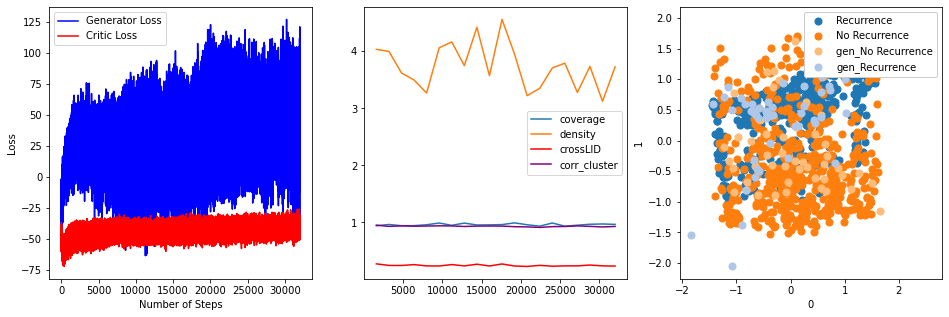

100%|██████████████████████████████████████████████████████████████████████████| 32000/32000 [3:33:09<00:00,  2.50it/s]


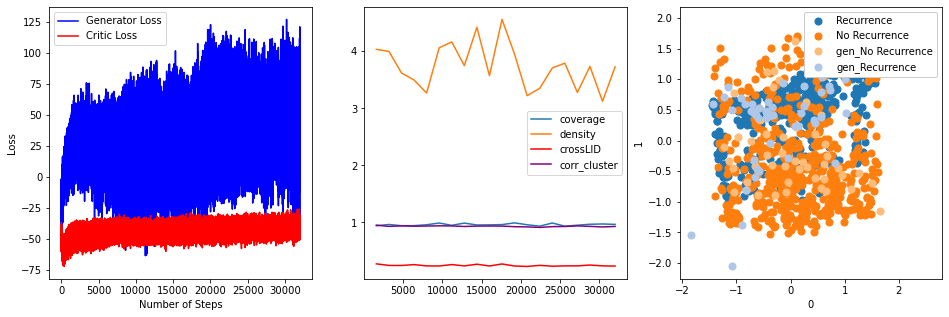

In [39]:
GENERATE = True
if GENERATE:
    # Store results
    gen_loss_all = []
    crit_loss_all = []
    saved_predictions = []
    coverage = []
    density = []
    crossLID = []
    corr1stcluster = []

    generator_optimizer = tf.keras.optimizers.RMSprop(1e-3)
    critic_optimizer = tf.keras.optimizers.RMSprop(1e-3)

    generator = generator_model(data_treated.shape[1], data_treated.shape[1], 128, 2)
    critic = critic_model(data_treated.shape[1], 128, 2)

    training_montage(data_treated, lbls, data_treated, lbls,
                     1000, generator, critic, generator_optimizer, critic_optimizer,
                     input_realdata_dist, batch_size, grad_pen_weight=5, k_cov_den=20, k_crossLID=15)

In [40]:
if GENERATE:
    # Save the generator and critic models' weights.
    generator.save_weights('gan_models/HD_gen_imb')
    critic.save_weights('gan_models/HD_crit_imb')
else:
    # Setting the model up
    generator_optimizer = tf.keras.optimizers.RMSprop(1e-3)
    critic_optimizer = tf.keras.optimizers.RMSprop(1e-3)

    generator = generator_model(data_treated.shape[1], data_treated.shape[1], 128, 2)
    critic = critic_model(data_treated.shape[1], 128, 2)

    # Load Previously saved models
    generator.load_weights('./gan_models/HD_gen_imb')
    critic.load_weights('./gan_models/HD_crit_imb')

#### Generate examples from our new code

- Generate examples in bulk - predictions (GAN data)
- Select only the 5 most correlated generated samples with each of the original samples - corr_preds (CorrGAN Data)

In [41]:
num_examples_to_generate = 2048
test_input = tf.constant(input_realdata_dist.rvs(size=len(human_datamatrix_treated.columns)*num_examples_to_generate), 
                         shape=[num_examples_to_generate,len(human_datamatrix_treated.columns)])
test_labels = tf.constant([1]*(num_examples_to_generate//2) + [0]*(num_examples_to_generate//2), shape=[
        num_examples_to_generate,1])

predictions = generator([test_input, test_labels], training=False)
predictions = pd.DataFrame(predictions.numpy(), columns=human_datamatrix.columns)

See correlation between samples and choose the 5 most correlated generated samples for each of the original samples.

In [42]:
df = human_datamatrix_treated/(2*human_datamatrix_treated.values.std())
# Calculate all correlations between all samples of real and artificial data and store them in a dataframe
correlations = pd.DataFrame(index=predictions.index, columns=df.index).astype('float')

for i in df.index:
    for j in predictions.index:
        correlations.loc[j,i] = stats.pearsonr(df.loc[i],
                                               predictions.loc[j])[0]

In [43]:
# Indices to keep in the correlated GAN data
idx_to_keep = []
for i in correlations:
    idx_to_keep.extend(correlations[i].sort_values(ascending=False).index[:5])
    
print('Nº of total idx :', len(idx_to_keep))
print('Nº of unique idx:', len(set(idx_to_keep)))

Nº of total idx : 600
Nº of unique idx: 452


In [44]:
# Make the correlation GAN dataframe and corresponding label targets
corr_preds = predictions.loc[list(set(idx_to_keep))]
corr_lbls  = list(np.array(
    ['gen_No Recurrence']*(len(predictions)//2) + ['gen_Recurrence']*(len(predictions)//2))[list(set(idx_to_keep))])
#corr_lbls2  = list(np.array(
#    ['gen_No Recurrence']*(len(predictions)//2) + ['gen_Recurrence']*(len(predictions)//2))[list(set(idx_to_keep))])

In [45]:
# Redo prediction with a smaller number of samples this time
num_examples_to_generate = 1024
test_input = tf.constant(input_realdata_dist.rvs(size=len(human_datamatrix_treated.columns)*num_examples_to_generate), 
                         shape=[num_examples_to_generate,len(human_datamatrix_treated.columns)])
test_labels = tf.constant([1]*(num_examples_to_generate//2) + [0]*(num_examples_to_generate//2), shape=[
        num_examples_to_generate,1])

predictions = generator([test_input, test_labels], training=False)

In [46]:
critic([predictions, test_labels])

<tf.Tensor: shape=(1024, 1), dtype=float32, numpy=
array([[37.233433 ],
       [19.111584 ],
       [-6.7684164],
       ...,
       [19.087551 ],
       [63.479034 ],
       [19.217478 ]], dtype=float32)>

In [47]:
predictions = pd.DataFrame(predictions.numpy(), columns=human_datamatrix.columns)

### Inducing noise on Feature Occurrence Data and imputing intensity values Method Sample Generation

In [48]:
# Represents Binary Simplification pre-treatment
def df_to_bool(df):
    "Transforms data into 'binary' matrices."
    return df.mask(df.notnull(), 1).mask(df.isnull(), 0)

data_bin_hd = df_to_bool(human_datamatrix)
data_bin_hd

metabolite_name,71.06031304_0.064166667,71.06031992_9.984466667,126.1023924_4.038416667,121.0717995_1.358816667,105.0697004_2.574533333,83.06023778_3.971433333,85.02828928_2.7925,85.0282975_2.440233333,103.0539927_2.632416667,117.0695881_0.77655,...,370.0920791_2.0983,468.1567372_2.0983,727.5149425_2.0983,497.1417674_2.0983,400.1388094_2.0983,588.4147684_2.0983,177.1270579_2.0983,374.2064688_2.0983,211.0531259_2.0983,206.0808246_2.0983
S68_3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
S53_1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
S73_3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
S83_1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
S53_3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S43_2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
S3_1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
S28_1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
S30_3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [ ]:
# Generating Linearly Interpolated Feature Occurrence Data
GENERATE = True
if GENERATE:
    start = perf_counter()
    data_bin, lbls_bin = laf.artificial_dataset_generator(data_bin_hd, labels=hd_labels, max_new_samples_per_label=512,
                                                          binary='random sampling', rnd=list(np.linspace(0.2,0.8,3)), 
                                                          binary_rnd_state=314, rnd_state=341)
    end = perf_counter()
    print(f'Simple augmentation of data done! took {(end - start):.3f} s')
    
    # Store Linear Augmented Data
    data_treated.to_csv('store_data/HD_generated_bin_imbalanced.csv')

    # Store labels/classes corresponding to each generated sample
    with open('store_data/HD_data_bin_lbls_imbalanced.txt', 'w') as a:
        for item in lbls:
            a.write("{}\n".format(item))
        #print(lbls, file=a)

else:
    data_bin = pd.read_csv('store_data/HD_generated_bin_imbalanced.csv')
    data_bin = data_bin.set_index(data_bin.columns[0])
    #data_bin

    with open('store_data/HD_data_bin_lbls_imbalanced.txt') as a:
        lbls_bin = a.read().split('\n')[:-1]

In [43]:
# Inducing noise on linearly interpolated feature occurrence data
noise_df = data_bin.copy()
for i in tqdm(range(len(data_bin.index))):
    if data_bin.iloc[i].sum() == len(data_bin.columns):
        noise_df.iloc[i] = data_bin.iloc[i]
    elif lbls_bin[i] == 'Recurrence':
        noise_df.iloc[i] = laf.imbalanced_noise_inducer(
            data_bin.iloc[i], noise_fraction=0.10, method='random sampling', noise_fraction_changer=True,
            data = data_bin_hd.loc[np.array(hd_labels)=='Recurrence'])
    else:
        noise_df.iloc[i] = laf.imbalanced_noise_inducer(
            data_bin.iloc[i], noise_fraction=0.10, method='random sampling', noise_fraction_changer=True,
            data = data_bin_hd.loc[np.array(hd_labels)=='No Recurrence'])

100%|██████████████████████████████████████████████████████████████████████████████| 1024/1024 [00:27<00:00, 37.65it/s]


In [44]:
# Function to impute intensity values
def impute_intensity_values(df_bin, orig_data, labels=None, orig_labels=None):
    """From a binary dataframe impute intensities and missing values in 1 and 0 values, respectively.
       
       This is done according to the distributions of intensity in an original reference dataset.
       
       df_bin: Pandas DataFrame; data with binary data
       orig_data: Pandas DataFrame; original data with intensity
       labels: list; list of labels for each sample in the binary data; if None, the label '' is give to every sample
       orig_labels: list; list of labels for each samples in the original data with intensity; if None, the label '' is 
    give to every sample

       returns: Pandas DataFrame; binary dataset imputed with intensity values
       """
    df_int = pd.DataFrame(columns=df_bin.columns, index=df_bin.index)
    if labels == None:
        labels = ['']*len(df_bin)
        orig_labels = ['']*len(orig_data)

    df_int = pd.DataFrame(columns=df_bin.columns, index=df_bin.index) # DataFrame to put the intensity values
    
    # For each different class in the dataset
    for lbl in set(labels):
        
        df_orig = orig_data[[i==lbl for i in orig_labels]] # Reduce dataframe to samples of a label

        flat_values = df_orig.values.flatten() # Get the distribution of values of intensity in that label
        flat_values_red = np.log(flat_values[~np.isnan(flat_values)]) # Logarithmic distribution
        
        for i in df_bin[[i==lbl for i in labels]].columns:
            # See if the feature appears at least one time in the artificial dataset for the class of the aritificial sample
            if df_bin[[i==lbl for i in labels]][i].sum() == 0:
                continue

            # If a feature has different minimum and maximum (appears more than 1) in the real samples of the class
            if df_orig[i].notnull().sum() > 1:
                mini = np.log(df_orig[i]).min()
                maxi = np.log(df_orig[i]).max()
                dif = 0.15*(maxi-mini)
                #print(i, mini, maxi, dif)
            
            # If a feature has the same minimum and maximum (appears only once) in the real samples of the class
            elif df_orig[i].notnull().sum() == 1:
                mini = np.log(df_orig[i]).min()
                maxi = np.log(df_orig[i]).max()
                dif = 0.15*maxi
                #print(i, 1, mini,maxi,dif)
            
            # If a feature does not appear in the real samples of the class
            elif df_orig[i].notnull().sum() == 0:
                mini = np.log(df_orig).min().min()
                #maxi = np.log(df_orig).max().max()
                maxi = np.median(flat_values_red)
                dif = 0
                #print(i, 0, mini,maxi,dif)
            
            #print(i, mini, maxi)
            # Truncate the histogram values based on the minimum and maximum (and allowed extra margin)
            hist_values = flat_values_red[np.where((flat_values_red > mini-abs(dif)) & (flat_values_red < maxi+abs(dif)))]

            hist = np.histogram(hist_values, bins=50, density=True)
            prob_dist = stats.rv_histogram(hist)
            
            # Impute the intensity values for the needed samples for one feature
            for j in df_bin[[i==lbl for i in labels]].index:
                if df_bin.loc[j,i] == 1:
                    df_int.loc[j,i] = np.exp(prob_dist.rvs()) # Revert the logarithmic transformation
                    
    return df_int

In [45]:
# Impute intensity values based on the normalized dataset intensities
human_datamatrix_N
int_noise_df = impute_intensity_values(noise_df, human_datamatrix_N,
                    labels=lbls_bin, orig_labels=hd_labels)

In [76]:
# Data Pre-treatment of the noise induced data without normalization since it was already imputed from normalized data
imputed = transf.fillna_frac_min_feature(int_noise_df, fraction=0.2)
#norm = transf.normalize_PQN(imputed, ref_sample='mean')
int_noise_df = transf.pareto_scale(transf.glog(imputed.astype(float)))
int_noise_lbls = lbls_bin
int_noise_df

,71.06031304_0.064166667,71.06031992_9.984466667,126.1023924_4.038416667,121.0717995_1.358816667,105.0697004_2.574533333,83.06023778_3.971433333,85.02828928_2.7925,85.0282975_2.440233333,103.0539927_2.632416667,117.0695881_0.77655,...,370.0920791_2.0983,468.1567372_2.0983,727.5149425_2.0983,497.1417674_2.0983,400.1388094_2.0983,588.4147684_2.0983,177.1270579_2.0983,374.2064688_2.0983,211.0531259_2.0983,206.0808246_2.0983
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
Arti S75_2-S79_3_rnd0.2,4.080813,-1.257766,-2.518435,-2.038199,2.993451,-3.791396,1.185016,0.886594,-2.769726,-0.683079,...,3.369436,-2.810200,-4.769436,3.790417,0.626423,-3.890159,-0.339690,4.253194,-3.654597,2.332093
Arti S76_3-S83_1_rnd0.2,-1.220843,-1.257766,2.328764,0.260762,3.856970,-3.791396,2.430402,-0.491495,4.340860,2.329820,...,3.138817,-2.810200,-4.769436,0.047833,-1.618256,0.234172,-1.651267,4.308363,5.253504,1.848219
Arti S10_2-S76_2_rnd0.8,-1.220843,-1.257766,3.223225,-0.482537,-1.153971,0.681410,-0.140250,-0.823380,-1.883303,5.187321,...,-2.778888,2.519028,0.248740,-1.463408,-3.787285,-3.890159,1.331535,-2.158175,3.719856,-0.667513
Arti S57_2-S60_2_rnd0.2,0.055953,-1.257766,3.816376,3.214161,2.130661,-1.633026,-4.442607,1.702820,2.819344,-0.683079,...,2.104467,-2.810200,-0.054657,3.061281,2.945950,3.240710,-0.948213,1.039346,-3.654597,-1.116308
Arti S64_2-S76_1_rnd0.8,-1.220843,-1.257766,0.182330,2.263752,-2.737607,-1.230080,2.332909,-1.619360,2.216945,-0.683079,...,-2.778888,0.895046,2.968477,2.581603,0.050035,-3.890159,0.013919,-2.158175,5.936747,-3.768756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Arti S14_3-S29_2_rnd0.5,3.761338,-1.257766,0.452704,2.093308,0.140119,0.924743,2.103197,1.918162,2.904357,-0.683079,...,3.033468,4.036990,4.038179,-3.321443,2.199747,2.264177,2.504140,4.615818,-3.654597,3.526447
Arti S2_1-S4_1_rnd0.2,-1.220843,-1.257766,0.188913,3.077397,2.749403,3.416045,0.069833,1.304876,4.355788,-0.683079,...,0.857460,-1.417664,3.012714,2.491297,-1.431307,3.316766,3.700904,-2.158175,-3.654597,-2.729461
Arti S17_2-S20B_1_rnd0.2,3.002370,2.675393,-1.348342,-1.248848,0.858575,-0.173177,1.396747,-3.484053,-2.769726,-0.683079,...,3.753537,-2.810200,3.610915,3.363256,-1.833383,-3.890159,0.333521,4.717290,-3.654597,-0.958698


### Loss Plot and PCAs and tSNEs representation on the evolution of generated samples with epochs

Measures of progression of the model in time.

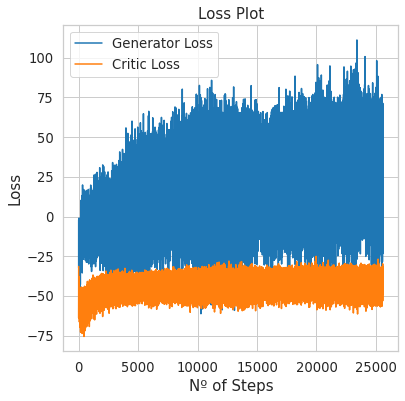

In [54]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, ax = plt.subplots(1, 1, figsize=(6,6))
        ax.plot(range(1,len(gen_loss_all)+1), gen_loss_all, label='Generator Loss')
        ax.plot(range(1,len(crit_loss_all)+1), crit_loss_all, label='Critic Loss')
        
        ax.legend()
        #ax.set_xticklabels(range(0,19000,2000), size=10)
        ax.set_xlabel('Nº of Steps', fontsize=15)
        ax.set_ylabel('Loss', fontsize=15)
        ax.set_title('Loss Plot', fontsize=15)

In [55]:
# Transform predictions into Pandas DataFrames
for i in range(len(saved_predictions)):
    saved_predictions[i] = pd.DataFrame(saved_predictions[i].numpy(), columns=human_datamatrix.columns)

**PCA and tSNE of GAN generated data and the linearly generated data**

Progression with number of epochs.

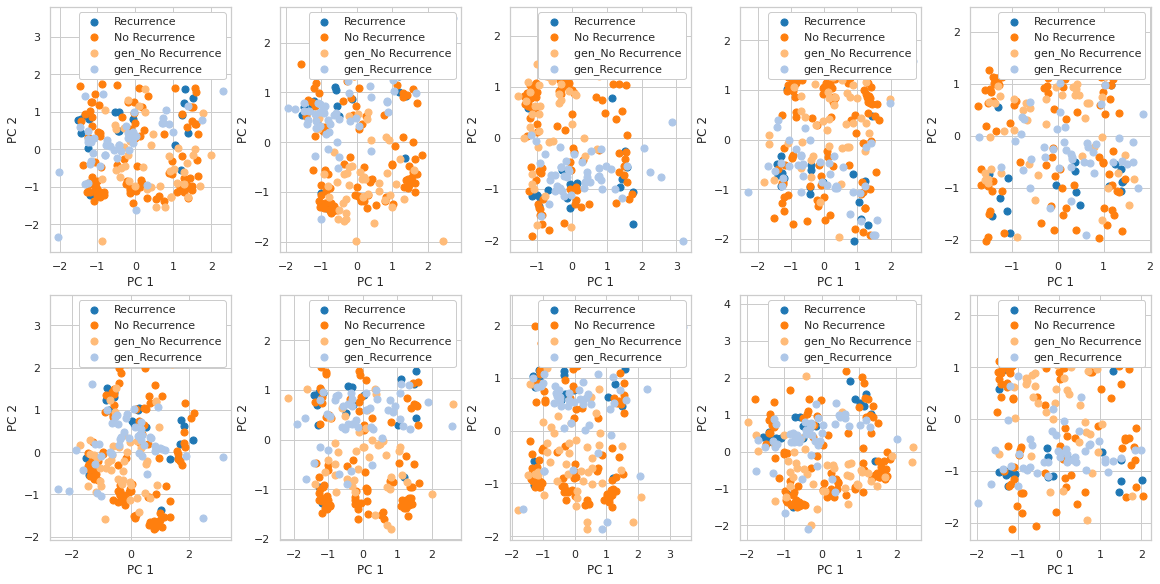

In [56]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1):
        f, axs = plt.subplots(2,5, figsize=(16,8), constrained_layout=True)
        
        for i, ax in zip(range(0, len(saved_predictions),2), axs.ravel()):
            dfs_temp = pd.concat((human_datamatrix_treated/(2*human_datamatrix_treated.values.std()),saved_predictions[i]))
            temp_lbls = hd_labels.copy()
            temp_lbls.extend(['gen_No Recurrence']*(len(saved_predictions[-1])//2))
            temp_lbls.extend(['gen_Recurrence']*(len(saved_predictions[-1])//2))
            
            principaldf = ma.compute_df_with_PCs(dfs_temp, n_components=2, whiten=True, labels=temp_lbls,
                                                 return_var_ratios=False)

            lcolors = label_colors_test
            
            gem.plot_PCA(principaldf, lcolors, components=(1,2), title='', ax=ax)
            #gem.plot_ellipses_PCA(principaldf, lcolors, components=(1,2),ax=ax, q=0.95)
            ax.legend(loc='upper right', ncol=1, framealpha=1)
        

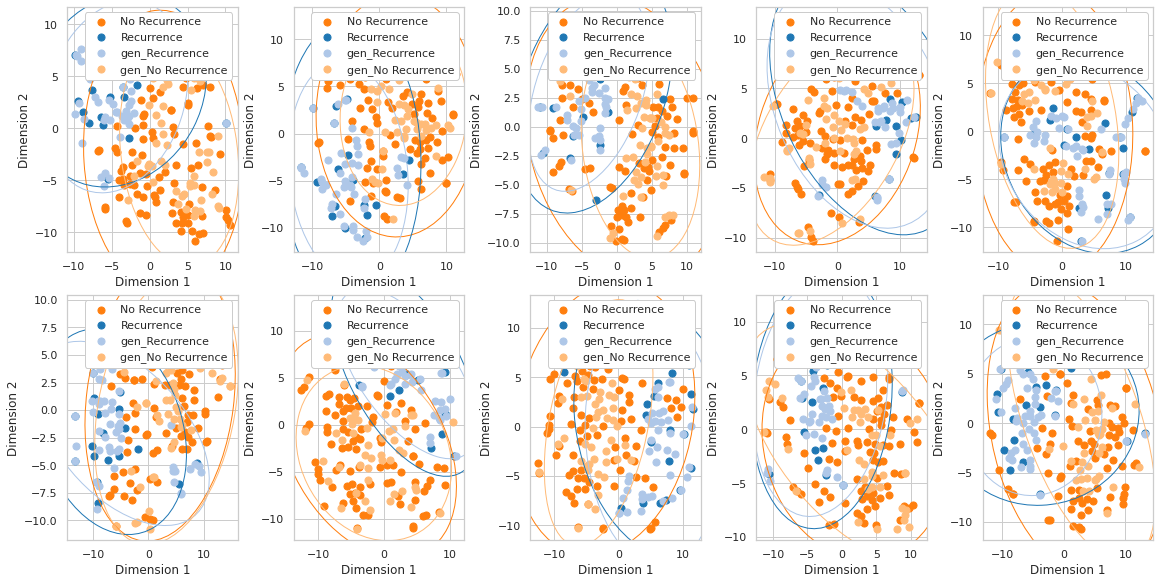

In [57]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1):
        f, axs = plt.subplots(2,5, figsize=(16,8), constrained_layout=True)
        
        for i, ax in zip(range(0, len(saved_predictions), 2), axs.ravel()):
            
            dfs_temp = pd.concat((human_datamatrix_treated/(2*human_datamatrix_treated.values.std()),saved_predictions[i]))
            temp_lbls = hd_labels.copy()
            temp_lbls.extend(['gen_No Recurrence']*(len(saved_predictions[-1])//2))
            temp_lbls.extend(['gen_Recurrence']*(len(saved_predictions[-1])//2))
            
            X = dfs_temp.copy()
            X_embedded = TSNE(n_components=2, perplexity=30, learning_rate='auto',
                              init='random', verbose=0).fit_transform(X)

            df = X_embedded
            labels = temp_lbls
            lcolors = label_colors_test
            
            gem.plot_tSNE(df, labels, lcolors, components=(1,2), title='', ax=ax)
            gem.plot_ellipses_tSNE(df, labels, lcolors, components=(1,2),ax=ax, q=0.95)
            ax.legend(loc='upper right', ncol=1, framealpha=1)

### Comparing GAN Generated Data Characteristics with other data

In [60]:
names = ['Real data', 'Interpolated Data', 'GAN data', 'CorrGAN data']
data_repo = [human_datamatrix_treated/(2*human_datamatrix_treated.values.std()), 
             data_treated/(2*data_treated.values.std()), predictions, corr_preds]
tgs = [hd_labels, lbls, ['gen_No Recurrence']*(len(predictions)//2) + ['gen_Recurrence']*(len(predictions)//2), corr_lbls]
data_characteristics = [gem.characterize_data(ds, name, tg) for ds,name,tg in zip(data_repo, names, tgs)]
data_characteristics = pd.DataFrame(data_characteristics).set_index('Dataset')
data_characteristics

,# samples,# features,feature value average (std),feature value ranges,feature value median,# classes,samples / class
Dataset,,,,,,,
Real data,120,12869,6.193116030338377e-18 (0.5000000000000002),(-4.246950646984248 - 4.764512788997524),-0.034617,2,60.0
Interpolated Data,1024,12869,-2.7241723265763065e-17 (0.4999999999999999),(-6.62882120553191 - 5.300307325827209),-0.023204,2,512.0
GAN data,1024,12869,0.0023610410280525684 (0.4746570885181427),(-5.685482025146484 - 9.353142738342285),-0.017840,2,512.0
CorrGAN data,461,12869,0.001193895237520337 (0.5589622259140015),(-5.995272159576416 - 10.144929885864258),-0.021746,2,230.5


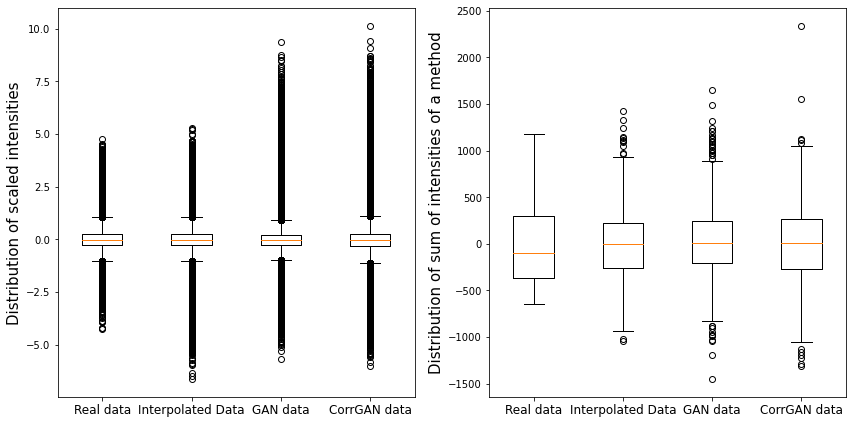

In [61]:
f, (axl, axr) = plt.subplots(1,2, figsize=(12,6))

axl.boxplot([ds.values.flatten() for ds in data_repo])
axl.set_ylabel('Distribution of scaled intensities', fontsize=15)
axl.set_xticklabels(names, fontsize=12)
#axl.set_yticks([-2, 0, 2, 4])

axr.boxplot([ds.sum(axis=1) for ds in data_repo])
axr.set_ylabel('Distribution of sum of intensities of a method', fontsize=15)
axr.set_xticklabels(names, fontsize=12)

plt.tight_layout()
plt.show()

### Hierarchical Clustering

Hierarchical clustering of the latest predictions and testing data (96 random samples from real data). 

In [62]:
# Hierarchical clustering of the latest predictions and real data, 
# saving the correct 1st cluster fraction results
dt = human_datamatrix_treated/(2*human_datamatrix_treated.values.std())
dfs_temp = np.concatenate((dt, saved_predictions[-1].values))
test_labels = hd_labels
temp_lbls = list(test_labels) + ['gen_No Recurrence']*(len(saved_predictions[-1])//2) + ['gen_Recurrence']*(len(
    saved_predictions[-1])//2)

hca_results = gem.perform_HCA(dfs_temp, temp_lbls, metric='euclidean', method='average')

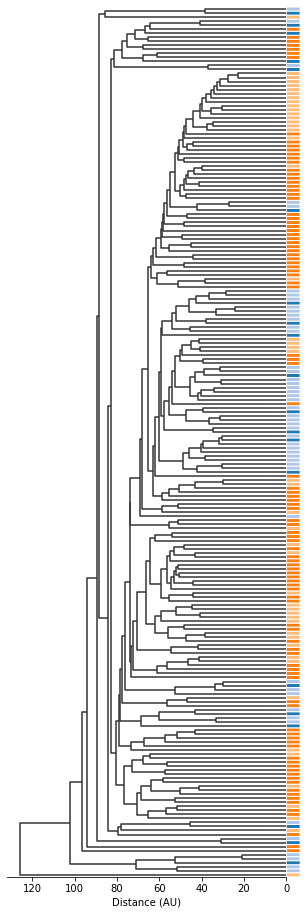

In [64]:
f, ax = plt.subplots(figsize=(5, 16))
gem.plot_dendogram(hca_results['Z'], 
               temp_lbls, ax=ax,
               label_colors=label_colors_test, title='',
               color_threshold=0)
ax.set_yticklabels([])
#plt.legend(ordered_labels_test, colours2)
plt.show()

In [67]:
# Hierarchical clustering of the CorrGAN and real data, 
# saving the correct 1st cluster fraction results
dt = human_datamatrix_treated/(2*human_datamatrix_treated.values.std())
dfs_temp = np.concatenate((dt, corr_preds.values))
test_labels = hd_labels
temp_lbls = list(test_labels) + list(corr_lbls)

hca_results = gem.perform_HCA(dfs_temp, temp_lbls, metric='euclidean', method='average')

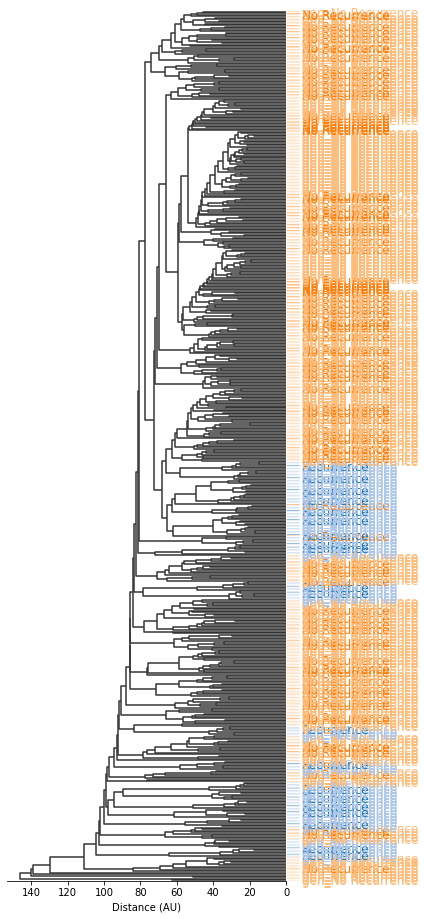

In [68]:
f, ax = plt.subplots(figsize=(5, 16))
gem.plot_dendogram(hca_results['Z'], 
               temp_lbls, ax=ax,
               label_colors=label_colors_test, title='',
               color_threshold=0)

### Coverage and Density

In [69]:
# Calculating Coverage and Density
dt = human_datamatrix_treated/(2*human_datamatrix_treated.values.std())
density_list, coverage_list = gem.evaluation_coverage_density_all_k_at_once(dt, predictions, 
                                                                            metric='Euclidean')

corr_density_list, corr_coverage_list = gem.evaluation_coverage_density_all_k_at_once(dt, corr_preds, 
                                                                            metric='Euclidean')

density_list_lin, coverage_list_lin = gem.evaluation_coverage_density_all_k_at_once(dt, 
                                                            data_treated/(2*data_treated.values.std()), metric='Euclidean')

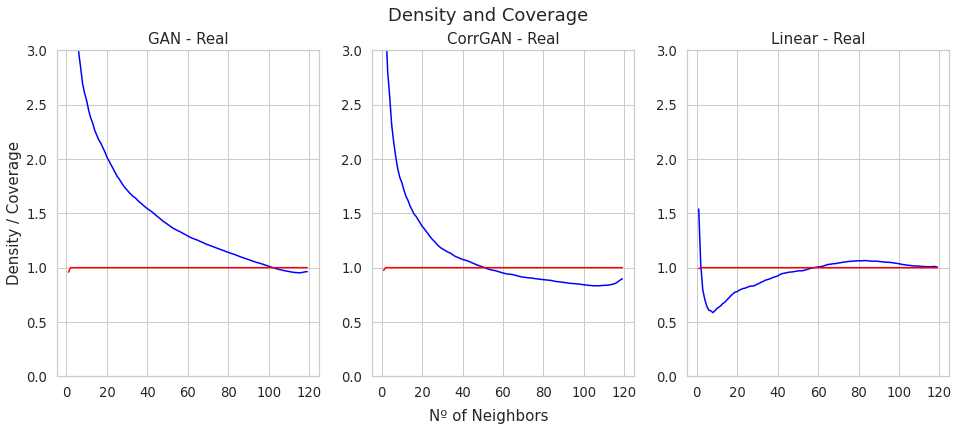

In [70]:
# Plotting the results
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, (axl, axc, axr) = plt.subplots(1, 3, figsize = (16,6))#, sharey='row')#, sharex='col')
        
        axl.plot(range(1,len(human_datamatrix_treated)), density_list, label='Density', color='blue')
        axl.plot(range(1,len(human_datamatrix_treated)), coverage_list, label='Coverage', color='red')
        axl.set_title('GAN - Real', fontsize=15)
        axl.set_ylabel('Density / Coverage', fontsize=15)
        axl.set_ylim([0,3])
        
        axc.plot(range(1,len(human_datamatrix_treated)), corr_density_list, label='Density', color='blue')
        axc.plot(range(1,len(human_datamatrix_treated)), corr_coverage_list, label='Coverage', color='red')
        axc.set_title('CorrGAN - Real', fontsize=15)
        axc.set_ylim([0,3])
        
        axr.plot(range(1,len(human_datamatrix_treated)), density_list_lin, label='Density', color='blue')
        axr.plot(range(1,len(human_datamatrix_treated)), coverage_list_lin, label='Coverage', color='red')
        axr.set_title('Linear - Real', fontsize=15)
        axr.set_ylim([0,3])
        
        plt.suptitle('Density and Coverage', fontsize=18)

    f.text(0.5, 0.05, 'Nº of Neighbors', ha='center', va='top', fontsize=15)

### CrossLID (Local Intrinsic Dimensionality) Evaluation

In [71]:
CrossLIDs = {}

c_lid = gem.cross_LID_estimator_byMLE_all_k_at_once(dt, predictions, 
                                                metric='euclidean')
CrossLIDs['RealVGAN'] = c_lid
print('Real - GAN Done')

c_lid = gem.cross_LID_estimator_byMLE_all_k_at_once(dt, corr_preds, 
                                                metric='euclidean')
CrossLIDs['RealVCorrGAN'] = c_lid
print('Real - CorrGAN Done')

c_lid = gem.cross_LID_estimator_byMLE_all_k_at_once(dt, data_treated/(2*data_treated.values.std()), 
                                                metric='euclidean')
CrossLIDs['RealVLinear'] = c_lid
print('Real - Linear Done')

Real - GAN Done
Real - CorrGAN Done
Real - Linear Done


In [72]:
LIDs = {}

lid = gem.local_intrinsic_dimensionality_estimator_byMLE_all_k_at_once(predictions, metric='euclidean')
LIDs['GAN'] = lid
print('GAN Data Done')

lid = gem.local_intrinsic_dimensionality_estimator_byMLE_all_k_at_once(corr_preds, metric='euclidean')
LIDs['CorrGAN'] = lid
print('CorrGAN Data Done')

lid = gem.local_intrinsic_dimensionality_estimator_byMLE_all_k_at_once(dt, metric='euclidean')
LIDs['Real'] = lid
print('Real Data Done')

lid = gem.local_intrinsic_dimensionality_estimator_byMLE_all_k_at_once(data_treated/(2*data_treated.values.std()),
                                                                       metric='euclidean')
LIDs['Linear'] = lid
print('Linear Data Done')

GAN Data Done
CorrGAN Data Done
Real Data Done
Linear Data Done


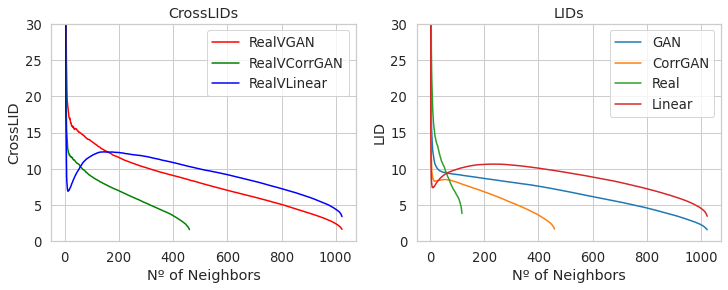

In [74]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, (axl, axr) = plt.subplots(1, 2, figsize=(12,4))
        c = {'RealVGAN': 'Red', 'RealVLinear': 'Blue', 'RealVCorrGAN': 'Green'}
        for l, data in CrossLIDs.items():
            axl.plot(range(2,len(data)+2), data, label=l, color = c[l])
            
        axl.set_ylim([0,30])
        axl.legend()
        axl.set(xlabel='Nº of Neighbors', ylabel='CrossLID', title='CrossLIDs')
        
        c = {'GAN': 'Red', 'Linear': 'Orange', 'Real': 'Blue', 'CorrGAN':'Green'}
        for l, data in LIDs.items():
            axr.plot(range(2,len(data)+2), data, label=l)
            
        axr.set_ylim([0,30])
        axr.legend()
        axr.set(xlabel='Nº of Neighbors', ylabel='LID', title='LIDs')

### Histograms
 
Histograms of Values of normal Real, Generated and GAN Generated Data.

In [75]:
# Predictions reverting the division by the standard deviation
last_preds = predictions*(2*data_treated.values.std())
dt = human_datamatrix_treated

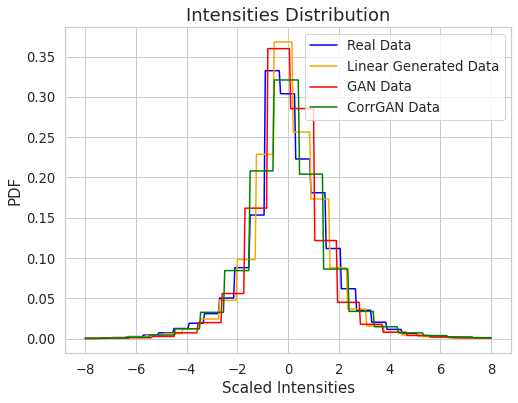

In [76]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, ax = plt.subplots(1, 1, figsize = (8,6))#, sharey='row')#, sharex='col')
        X = np.arange(-8, 8.01, 0.05)
        hist = np.histogram(dt.values.flatten(), bins=50)
        hist_dist = stats.rv_histogram(hist)
        ax.plot(X, hist_dist.pdf(X), color='blue', label='Real Data')
        
        hist = np.histogram(data_treated.values.flatten(), bins=50)
        hist_dist = stats.rv_histogram(hist)
        ax.plot(X, hist_dist.pdf(X), color='orange', label='Linear Generated Data')
        ax.set_ylabel('PDF', fontsize=15)
        
        hist = np.histogram(last_preds.values.flatten(), bins=50)
        hist_dist = stats.rv_histogram(hist)
        ax.plot(X, hist_dist.pdf(X), color='red', label='GAN Data')
        
        hist = np.histogram((corr_preds*(2*data_treated.values.std())).values.flatten(), bins=50)
        hist_dist = stats.rv_histogram(hist)
        ax.plot(X, hist_dist.pdf(X), color='green', label='CorrGAN Data')
        
        ax.set_ylabel('PDF', fontsize=15)
        ax.set_xlabel('Scaled Intensities', fontsize=15)

        ax.legend()
        ax.set_title('Intensities Distribution', fontsize=18)

### Correlations between samples of Real Data and GAN Generated Data

In [78]:
correlation_real_real = gem.create_sample_correlations(dt, dt,
                                                   method='pearson')
print('Correlation Real-Real calculation ended.')
correlation_real_gan = gem.create_sample_correlations(dt, last_preds,
                                                   method='pearson')
print('Correlation Real-GAN calculation ended.')
correlation_gan_gan = gem.create_sample_correlations(last_preds, last_preds,
                                                   method='pearson')
print('Correlation GAN-GAN calculation ended.')

correlation_corr_corr = gem.create_sample_correlations(corr_preds, corr_preds,
                                                   method='pearson')
print('Correlation corrGAN-corrGAN calculation ended.')

Correlation Real-Real calculation ended.
Correlation Real-GAN calculation ended.
Correlation GAN-GAN calculation ended.
Correlation corrGAN-corrGAN calculation ended.


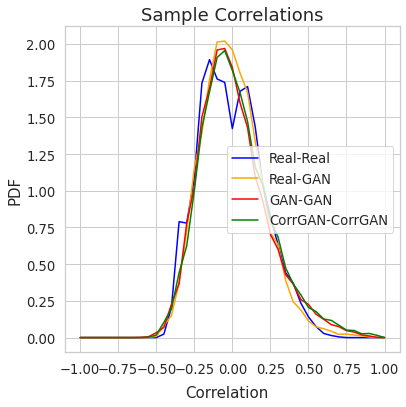

In [79]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, ax = plt.subplots(1, 1, figsize = (6,6))#, sharey='row')#, sharex='col')
        X = np.arange(-1, 1.01, 0.05)
        hist = np.histogram(correlation_real_real.values.flatten(), bins=50)
        hist_dist = stats.rv_histogram(hist)
        ax.plot(X, hist_dist.pdf(X), color='blue', label='Real-Real')
        ax.set_ylabel('PDF', fontsize=15)
        
        hist = np.histogram(correlation_real_gan.values.flatten(), bins=50)
        hist_dist = stats.rv_histogram(hist)
        ax.plot(X, hist_dist.pdf(X), color='orange', label='Real-GAN')
        
        hist = np.histogram(correlation_gan_gan.values.flatten(), bins=50)
        hist_dist = stats.rv_histogram(hist)
        ax.plot(X, hist_dist.pdf(X), color='red', label='GAN-GAN')
        
        hist = np.histogram(correlation_corr_corr.values.flatten(), bins=50)
        hist_dist = stats.rv_histogram(hist)
        ax.plot(X, hist_dist.pdf(X), color='green', label='CorrGAN-CorrGAN')
        
        ax.legend()
        ax.set_title('Sample Correlations', fontsize=18)

    f.text(0.5, 0.05, 'Correlation', ha='center', va='top', fontsize=15)

### Correlations between features of Real, Generated and GAN Generated Samples

In [ ]:
correlation_real_real = gem.create_sample_correlations(dt.T, dt.T,
                                                   method='pearson')
print('Correlation Real-Real calculation ended.')

correlation_gan_gan = gem.create_sample_correlations(last_preds.T, last_preds.T,
                                                   method='pearson')
print('Correlation GAN-GAN calculation ended.')

correlation_corr_corr = gem.create_sample_correlations(corr_preds.T, corr_preds.T,
                                                   method='pearson')
print('Correlation CorrGAN-CorrGAN calculation ended.')

In [ ]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, ax = plt.subplots(1, 1, figsize = (6,6))#, sharey='row')#, sharex='col')
        X = np.arange(-1, 1.01, 0.05)
        hist = np.histogram(correlation_real_real.values.flatten()[~np.isnan(correlation_real_real.values.flatten())], bins=50)
        hist_dist = stats.rv_histogram(hist)
        ax.plot(X, hist_dist.pdf(X), color='blue', label='Real-Real')
        ax.set_ylabel('PDF', fontsize=15)
        
        hist = np.histogram(correlation_gan_gan.values.flatten()[~np.isnan(correlation_gan_gan.values.flatten())], bins=50)
        hist_dist = stats.rv_histogram(hist)
        ax.plot(X, hist_dist.pdf(X), color='red', label='GAN-GAN')
        
        hist = np.histogram(correlation_corr_corr.values.flatten()[~np.isnan(correlation_corr_corr.values.flatten())], bins=50)
        hist_dist = stats.rv_histogram(hist)
        ax.plot(X, hist_dist.pdf(X), color='green', label='CorrGAN-CorrGAN')
        
        ax.legend(loc='lower left')
        ax.set_title('Feature Correlations', fontsize=18)

    f.text(0.5, 0.05, 'Correlation', ha='center', va='top', fontsize=15)

### Sample Correlation Matrix

Between samples of the real data and a set of generated artificial samples of GANs

In [80]:
# Real Data, organize it to have first all samples of a class, then all samples of the other class
df = human_datamatrix_treated.copy()

samp = df.index
tg = hd_labels.copy()
new_order = [x for _, x in sorted(zip(tg, samp))]
new_tg = [x for x, _ in sorted(zip(tg, samp))]

df = df.loc[new_order]
#df

In [81]:
# Calculate all correlations between all samples of real and artificial data and store them in a dataframe
correlations = pd.DataFrame(index=last_preds.index, columns=df.index).astype('float')

for i in df.index:
    for j in last_preds.index:
        correlations.loc[j,i] = stats.pearsonr(df.loc[i],
                                               last_preds.loc[j])[0]

correlations.columns = new_tg
correlations.index = ['gen_No Recurrence']*(len(last_preds)//2) + ['gen_Recurrence']*(len(last_preds)//2)

C:\Users\franc\anaconda3\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


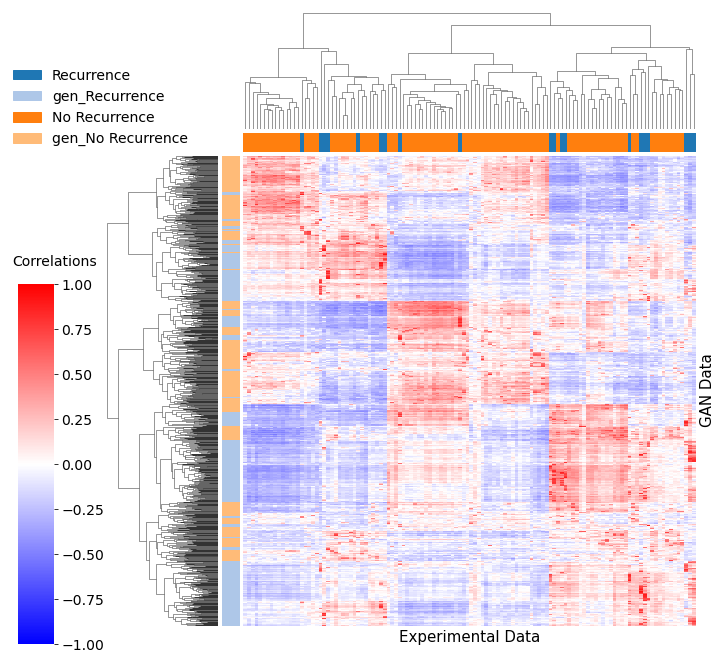

In [82]:
# Draw the clustermap
import matplotlib.patches as mpatches

row_cols = [label_colors_test[lbl] for lbl in new_tg]
row_cols2 = [label_colors_test[lbl] for lbl in correlations.index]
g = sns.clustermap(correlations, col_colors=row_cols, cmap='bwr', row_colors= row_cols2, vmin=-1, vmax=1,
                  cbar_pos = (-0.1, 0.1, 0.05, 0.5))
g.fig.set_size_inches((10,10))
# some tweaks
patches = []
for lbl in ordered_labels_test:
    patches.append(mpatches.Patch(color=label_colors_test[lbl], label=lbl))
leg = plt.legend(handles=patches, loc=3, bbox_to_anchor=(-0.5, 1.35, 0.5, 1),
                     frameon=False, fontsize=14) 
g.ax_heatmap.set_ylabel('GAN Data', fontsize=15)
g.ax_heatmap.set_xlabel('Experimental Data', fontsize=15)
g.ax_heatmap.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, labelright=False)

# Manually specify colorbar labelling after it's been generated
colorbar = g.ax_heatmap.collections[0].colorbar
colorbar.ax.tick_params(labelsize=14) 
plt.text(1, 1.10, 'Correlations', fontsize=14, horizontalalignment='center')
#g.savefig('clustermap_Tryp.png' , dpi=300)
plt.show()

### Supervised analysis

First generate artificial samples and choose the most correlated ones with the Recurrence samples. Then add 80 of those samples to the imbalanced dataset to make it balanced.

In [52]:
# Calculate correlations only against the 'Recurrence' samples
df = (human_datamatrix_treated/(2*human_datamatrix_treated.values.std())).iloc[:20]
# Calculate all correlations between all samples of real and artificial data and store them in a dataframe
df_corr = pd.DataFrame(columns=corr_preds.columns)
for i in range(len(corr_preds)):
    if corr_lbls[i] == 'gen_Recurrence':
        df_corr.loc[corr_preds.index[i]] = corr_preds.iloc[i]

#print(df_corr)

In [53]:
# See correlations of GAN data to the 20 Recurrence samples
df = (human_datamatrix_treated/(2*human_datamatrix_treated.values.std())).iloc[:20]
correlations = pd.DataFrame(index=df_corr.index, columns=df.index).astype('float')

for i in df.index:
    for j in df_corr.index:
        correlations.loc[j,i] = stats.pearsonr(df.loc[i],
                                               df_corr.loc[j])[0]

In [54]:
# Choose around 80 of them (80 is the difference between the number of samples of both datasets)
idx_to_keep = []
for i in correlations:
    idx_to_keep.extend(correlations[i].sort_values(ascending=False).index[:4])
    
print('Nº of total idx :', len(idx_to_keep))
print('Nº of unique idx:', len(set(idx_to_keep)))

Nº of total idx : 80
Nº of unique idx: 80


In [55]:
# Add the 80 GAN correlated GAN samples to the the imbalanced dataset, making it a balanced dataset
concat_df = pd.concat((df_corr.loc[list(set(idx_to_keep))]*(2*data_treated.values.std()), human_datamatrix_treated))
concat_lbls = ['Recurrence']*len(set(idx_to_keep)) + hd_labels

Creating dataset repository to be used for testing

In [72]:
# Creating the list of 'targets' (labels of samples) of the dataset with the 'No Recurrence' and 'Recurrence' classes 
original_labels = ['Recurrence']*114 + ['No Recurrence']*135

In [73]:
names = ['Real data', 'Linear Data', 'GAN data', 'CorrGAN data', 'Imbalanced Set', 'Balanced Set']
data_repo = [hd_datamatrix_treated, data_treated, predictions*(2*data_treated.values.std()), 
             corr_preds*(2*data_treated.values.std()), human_datamatrix_treated, concat_df]
tgs = [original_labels, lbls, ['No Recurrence']*(len(predictions)//2) + ['Recurrence']*(len(predictions)//2),
      [i[4:] for i in corr_lbls], hd_labels, concat_lbls]

In [74]:
# Transforming into dict
dfs = dict(zip(names, data_repo))
dfs_lbl = dict(zip(names, tgs))

#### Random Forest and PLS-DA models and cross-validation

Random Forest

In [59]:
# Optimization of the number of trees
GENERATE = True
np.random.seed(5)
if GENERATE:

    top_tree_in_grid=200
    
    #Vector with values for the parameter n_estimators
    # Models will be built from 10 to 200 trees in 2 tree intervals
    values = {'n_estimators': range(10,top_tree_in_grid,5)}
    
    rf = skensemble.RandomForestClassifier(n_estimators=200)
    clf = GridSearchCV(rf, values, cv=5)

    # For each dataset,building the Random Forest models with the different number of trees
    # and storing the predictive accuracy
    RF_optim = {}
    for n, df in dfs.items():
        print('Fitting to', n, '...', end=' ')
        rfname = n
        RF_optim[rfname] = {}
        clf.fit(df, dfs_lbl[n])

        RF_optim[rfname]['scores'] = list(clf.cv_results_['mean_test_score'])
        RF_optim[rfname]['n_trees'] = list(clf.cv_results_['param_n_estimators'])

        print('Done!')

Fitting to Real data ... Done!
Fitting to Linear Data ... Done!
Fitting to GAN data ... Done!
Fitting to CorrGAN data ... Done!
Fitting to Imbalanced Set ... Done!
Fitting to Balanced Set ... Done!


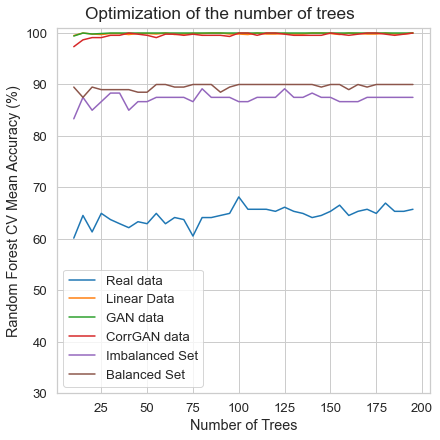

In [60]:
# Plotting the results and adjusting parameters of the plot

def plot_RF_otimization_ntrees(RF_optim, ax=None, ylabel='', title='', ylim=(30,101)):
    p7 = sns.color_palette('tab10', 6)

    if ax is None:
        ax = plt.gca()
    for name, color in zip(RF_optim.keys(), p7):
        ax.plot(RF_optim[name]['n_trees'], [s*100 for s in RF_optim[name]['scores']], label=name, color=color)
    ax.set(ylabel=ylabel, xlabel='Number of Trees', ylim=ylim, title=title)
    ax.legend()

with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, ax = plt.subplots(1, 1, figsize=(6,6), constrained_layout=True)
        
        plot_RF_otimization_ntrees(RF_optim, ax=ax,
                                   ylabel='Random Forest CV Mean Accuracy (%)',
                                   title='')

        f.suptitle('Optimization of the number of trees')

        plt.show()

In [62]:
iter_num=10

RF_all = {}

# Application of the Random Forests for each differently-treated dataset
for name, dataset in dfs.items():
    print(f'Fitting random forest for {name}', end=' ...')
    rfname = name
    RF_all[rfname] = {'dskey': name}
    n_fold = 5

    fit = ma.RF_model_CV(dataset, dfs_lbl[name], iter_num=iter_num, n_fold=n_fold, n_trees=100)
    RF_all[rfname].update(fit)

    print(f'done')    

Fitting random forest for Real data ...done
Fitting random forest for Linear Data ...done
Fitting random forest for GAN data ...done
Fitting random forest for CorrGAN data ...done
Fitting random forest for Imbalanced Set ...done
Fitting random forest for Balanced Set ...done


In [64]:
# Accuracy
accuracies = pd.DataFrame({name: RF_all[name]['accuracy'] for name in RF_all})
accuracy_stats = pd.DataFrame({'Average accuracy': accuracies.mean(axis=0),
                               'STD': accuracies.std(axis=0)})
accuracy_stats = accuracy_stats.assign(dataset=[name for name in RF_all])
accuracy_stats

,Average accuracy,STD,dataset
Real data,0.899151,0.016612,Real data
Linear Data,0.999804,0.000412,Linear Data
GAN data,1.000000,0.000000,GAN data
CorrGAN data,0.997556,0.001946,CorrGAN data
Imbalanced Set,0.891667,0.013608,Imbalanced Set
Balanced Set,0.948000,0.010328,Balanced Set


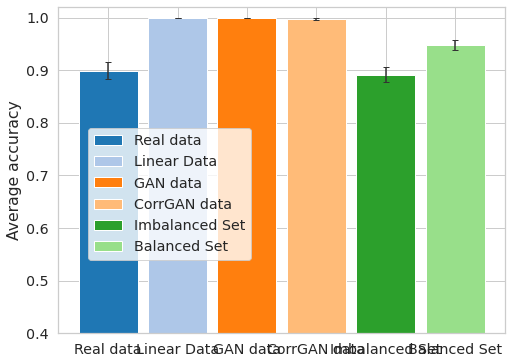

In [65]:
# Plot results
p4 = sns.color_palette('tab20', 9)
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.3):
        f, ax = plt.subplots(1, 1, figsize=(8, 6))
        x = 1  # the label locations
        width = 0.17  # the width of the bars
        for i, dataset in enumerate(accuracy_stats.index):
            acc_treatment = accuracy_stats[accuracy_stats['dataset']==dataset]
            offset = - 0.8 + i * 0.2
            rects = ax.bar(x + offset, acc_treatment['Average accuracy'], width, label=dataset, color = p4[i])
            ax.errorbar(x + offset, y=acc_treatment['Average accuracy'], yerr=acc_treatment['STD'],
                        ls='none', ecolor='0.2', capsize=3)
        ax.set_xticks([0.2+i*0.2 for i in range(len(accuracy_stats.index))])
        ax.set_xticklabels(accuracy_stats.index)
        ax.set(ylabel='Average accuracy', title='', ylim=(0.4,1.02))
        ax.legend(loc='upper left', bbox_to_anchor=(0.05, 0.65))

PLS-DA

In [ ]:
%%capture --no-stdout
# above is to supress PLS warnings

# Optimization of the number of components
max_comp=10

# Store Results
PLS_optim = {}

# Build and extract metrics from models build with different number of components by using the optim_PLS function.
for name, dataset in dfs.items():
    print(f'Fitting PLS-DA model for {name}', end=' ...')
    plsdaname = name
    PLS_optim[plsdaname] = {'dskey': name}
    n_fold = 5
    optim = ma.optim_PLSDA_n_components(dataset, dfs_lbl[name],
                                        max_comp=max_comp, n_fold=n_fold).CVscores
    PLS_optim[plsdaname]['CV_scores'] = optim
    print(f'done')

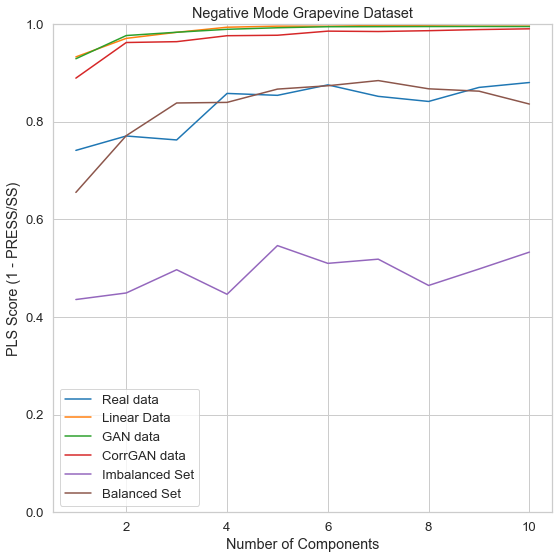

In [105]:
# Plotting the results and adjusting plot parameters
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, ax = plt.subplots(1, 1, figsize = (6,6))
        for name, data in PLS_optim.items():

            # Negative Grapevine Dataset
            ax.plot(range(1, len(data['CV_scores']) + 1), data['CV_scores'],
                     label=name)
            ax.set(xlabel='Number of Components',
                    ylabel='PLS Score (1 - PRESS/SS)',
                    title='Negative Mode Grapevine Dataset')
            ax.legend()
            ax.set_ylim([0, 1])

        plt.tight_layout()
        plt.show()

In [63]:
%%capture --no-stdout

# Fit all PLS-DA models
PLSDA_all = {}

# NOTE: for debugging
iter_num=20

for name, dataset in dfs.items():
    print(f'Fitting a PLS-DA model {name}', end=' ...')
    plsdaname = name
    PLSDA_all[plsdaname] = {'dataset':name}
    n_comp = 6
    n_fold = 5
    fit = ma.PLSDA_model_CV(dataset, dfs_lbl[name],
                            n_comp=n_comp, n_fold=n_fold,
                            iter_num=iter_num,
                            feat_type='Coef')
    PLSDA_all[plsdaname].update(fit)
    print(f'done')     

Fitting a PLS-DA model Real data ...done
Fitting a PLS-DA model Linear Data ...done
Fitting a PLS-DA model GAN data ...done
Fitting a PLS-DA model CorrGAN data ...done
Fitting a PLS-DA model Imbalanced Set ...done
Fitting a PLS-DA model Balanced Set ...done


In [66]:
accuracies = pd.DataFrame({name: PLSDA_all[name]['accuracy'] for name in PLSDA_all})
accuracy_stats = pd.DataFrame({'Average accuracy': accuracies.mean(axis=0),
                               'STD': accuracies.std(axis=0)})
accuracy_stats = accuracy_stats.assign(dataset=[PLSDA_all[name]['dataset'] for name in PLSDA_all])
accuracy_stats

,Average accuracy,STD,dataset
Real data,0.972289,0.013345,Real data
Linear Data,1.000000,0.000000,Linear Data
GAN data,1.000000,0.000000,GAN data
CorrGAN data,0.999115,0.002628,CorrGAN data
Imbalanced Set,0.910417,0.012645,Imbalanced Set
Balanced Set,0.974750,0.010321,Balanced Set


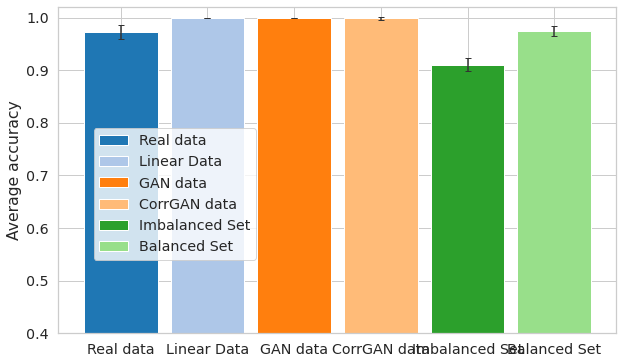

In [67]:
p4 = sns.color_palette('tab20', 9)
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.3):
        f, ax = plt.subplots(1, 1, figsize=(10, 6))
        x = 1  # the label locations
        width = 0.17  # the width of the bars
        for i, dataset in enumerate(accuracy_stats.index):
            acc_treatment = accuracy_stats[accuracy_stats['dataset']==dataset]
            offset = - 0.8 + i * 0.2
            rects = ax.bar(x + offset, acc_treatment['Average accuracy'], width, label=dataset, color = p4[i])
            ax.errorbar(x + offset, y=acc_treatment['Average accuracy'], yerr=acc_treatment['STD'],
                        ls='none', ecolor='0.2', capsize=3)
        ax.set_xticks([0.2+i*0.2 for i in range(len(accuracy_stats.index))])
        ax.set_xticklabels(accuracy_stats.index)
        ax.set(ylabel='Average accuracy', title='', ylim=(0.4,1.02))
        ax.legend(loc='upper left', bbox_to_anchor=(0.05, 0.65))

### Testing the models with the test set with mainly samples of the  Recurrence samples

**Random Forest Tests**

In [75]:
RF_models = {}
# Fitting the model
for name, dataset in dfs.items():
    RF_models[name] = ma.RF_model(dataset, dfs_lbl[name], return_cv=True, iter_num=1, n_trees=200, cv=None, n_fold=5)
    
    print(name, ':', np.mean(RF_models[name]['cv_scores']['test_score'])*100, '%.')

Real data : 91.5673469387755 %.
Linear Data : 100.0 %.
GAN data : 100.0 %.
CorrGAN data : 99.12087912087912 %.
Imbalanced Set : 89.16666666666669 %.
Balanced Set : 93.5 %.


In [76]:
RF_results = {}
r_data = test_datamatrix_treated#/(2*test_datamatrix_treated.values.std())
r_labels = pd.get_dummies(test_data_labels).values[:,0]
r_labels = test_data_labels
# Testing the real data
for name, model in RF_models.items():
    preds = RF_models[name]['model'].predict(r_data)
    RF_results[name] = {'Accuracy': RF_models[name]['model'].score(r_data, r_labels),
                        'F1-Score': f1_score(r_labels, preds, pos_label='Recurrence')}
    #print(preds)
    print(name, 'accuracy:', RF_results[name]['Accuracy']*100, '%.')
    print(name, 'F1-Score:', RF_results[name]['F1-Score'])
    
#print(RF_results)

Real data accuracy: 91.59663865546219 %.
Real data F1-Score: 0.9438202247191011
Linear Data accuracy: 52.94117647058824 %.
Linear Data F1-Score: 0.5757575757575757
GAN data accuracy: 67.22689075630252 %.
GAN data F1-Score: 0.7547169811320755
CorrGAN data accuracy: 62.18487394957983 %.
CorrGAN data F1-Score: 0.6979865771812082
Imbalanced Set accuracy: 24.369747899159663 %.
Imbalanced Set F1-Score: 0.08163265306122448
Balanced Set accuracy: 57.14285714285714 %.
Balanced Set F1-Score: 0.6530612244897959


In [154]:
RF_results = {}
r_data = test_datamatrix_treated/(2*test_datamatrix_treated.values.std())
r_labels = pd.get_dummies(test_data_labels).values[:,0]
r_labels = test_data_labels
# Testing the real data
for name, model in RF_models.items():
    RF_results[name] = RF_models[name]['model'].score(r_data, r_labels)
    print(name, ':', RF_results[name]*100, '%.')
    
#print(RF_results)

Real data : 84.03361344537815 %.
Linear Data : 97.47899159663865 %.
GAN data : 78.15126050420169 %.
Corr GAN data : 62.18487394957983 %.
Imbalanced Set : 21.84873949579832 %.
Balanced Set : 48.739495798319325 %.


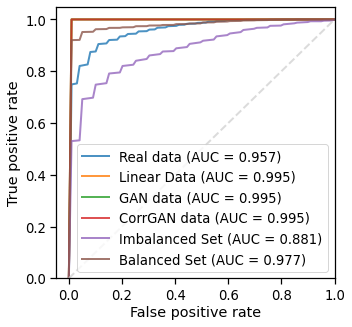

In [101]:
res_total = {}
for name, dataset in dfs.items():
    res_total[name] = ma.RF_ROC_cv(dataset, dfs_lbl[name], 'Recurrence', n_fold=5, n_trees=200, n_iter=50)

with sns.plotting_context("notebook", font_scale=1.2):
    f, ax = plt.subplots(1, 1, figsize=(5,5))
    for name, res in res_total.items():
        mean_fpr = res['average fpr']
        mean_tpr = res['average tpr']
        mean_auc = res['mean AUC']
        ax.plot(mean_fpr, mean_tpr,
               label=f'{name} (AUC = {mean_auc:.3f})',
               lw=2, alpha=0.8)

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='lightgrey', alpha=.8)
    ax.legend()
    ax.set_xlim(None,1)
    ax.set_ylim(0,None)
    ax.set(xlabel='False positive rate', ylabel='True positive rate', title='')
          # title="Random forest ROC curves for Vitis types data set")
    plt.show()

**PLS-DA Tests**

In [70]:
def decision_rule(y_pred, y_true):
    # Decision rule for classification
    # Decision rule chosen: sample belongs to group where it has max y_pred (closer to 1)
    # In case of 1,0 encoding for two groups, round to nearest integer to compare
    nright = 0
    rounded = np.round(y_pred)

    for p in range(len(y_pred)):
        if rounded[p] >= 1:
            pred = 1
        else:
            pred = 0
        if pred == y_true[p]:
            nright += 1  # Correct prediction

    # Calculate accuracy for this iteration
    accuracy = (nright / len(y_pred))
    return accuracy

In [77]:
PLSDA_results = {}
r_data = test_datamatrix_treated#/(2*test_datamatrix_treated.values.std())
#r_labels = ma._generate_y_PLSDA(test_data_labels, list(pd.unique(dfs_lbl[name])), True)
#r_labels = test_labels

# Fitting the model for each dataset
for name, dataset in dfs.items():
    
    plsda = ma.fit_PLSDA_model(dataset, dfs_lbl[name], n_comp=8, return_scores=False,
                    scale=False, encode2as1vector=True)
    # Obtain results with the test group
    r_labels = ma._generate_y_PLSDA(test_data_labels, list(pd.unique(dfs_lbl[name])), True)
    y_pred = plsda.predict(r_data)
    #ls = ma._generate_y_PLSDA(r_labels, list(pd.unique(dfs_lbl[name])), True)

    # Decision rule for classification
    # Decision rule chosen: sample belongs to group where it has max y_pred (closer to 1)
    # In case of 1,0 encoding for two groups, round to nearest integer to compare
    nright = 0
    rounded = np.round(y_pred)

    for p in range(len(y_pred)):
        if rounded[p] >= 1:
            pred = 1
            rounded[p] = 1
        else:
            pred = 0
            rounded[p] = 0
        if pred == r_labels[p]:
            nright += 1  # Correct prediction

    # Calculate accuracy
    accuracy = (nright / len(y_pred))

    PLSDA_results[name] = accuracy
    PLSDA_results[name] = {'Accuracy': accuracy,
                        'F1-Score': f1_score(r_labels, rounded, pos_label=0)}
    
    print(name, ':', accuracy*100, '%.')
    print(name, 'F1-Score:', f1_score(r_labels, rounded, pos_label=0))

Real data : 100.0 %.
Real data F1-Score: 1.0
Linear Data : 73.10924369747899 %.
Linear Data F1-Score: 0.6097560975609756
GAN data : 69.74789915966386 %.
GAN data F1-Score: 0.7692307692307693
CorrGAN data : 72.26890756302521 %.
CorrGAN data F1-Score: 0.7924528301886793
Imbalanced Set : 33.61344537815126 %.
Imbalanced Set F1-Score: 0.3875968992248062
Balanced Set : 40.33613445378151 %.
Balanced Set F1-Score: 0.4132231404958678


In [155]:
PLSDA_results = {}
r_data = test_datamatrix_treated#/(2*test_datamatrix_treated.values.std())
#r_labels = ma._generate_y_PLSDA(test_data_labels, list(pd.unique(dfs_lbl[name])), True)
#r_labels = test_labels

# Fitting the model for each dataset
for name, dataset in dfs.items():
    
    plsda = ma.fit_PLSDA_model(dataset, dfs_lbl[name], n_comp=8, return_scores=False,
                    scale=False, encode2as1vector=True)
    # Obtain results with the test group
    r_labels = ma._generate_y_PLSDA(test_data_labels, list(pd.unique(dfs_lbl[name])), True)
    y_pred = plsda.predict(r_data)
    #ls = ma._generate_y_PLSDA(r_labels, list(pd.unique(dfs_lbl[name])), True)

    # Decision rule for classification
    # Decision rule chosen: sample belongs to group where it has max y_pred (closer to 1)
    # In case of 1,0 encoding for two groups, round to nearest integer to compare
    nright = 0
    rounded = np.round(y_pred)

    for p in range(len(y_pred)):
        if rounded[p] >= 1:
            pred = 1
            rounded[p] = 1
        else:
            pred = 0
            rounded[p] = 0
        if pred == r_labels[p]:
            nright += 1  # Correct prediction

    # Calculate accuracy
    accuracy = (nright / len(y_pred))

    PLSDA_results[name] = accuracy
    PLSDA_results[name] = {'Accuracy': accuracy,
                        'F1-Score': f1_score(r_labels, rounded, pos_label=0)}
    
    print(name, ':', accuracy*100, '%.')
    print(name, 'F1-Score:', f1_score(r_labels, rounded, pos_label=0))

Real data : 100.0 %.
Real data F1-Score: 1.0
Linear Data : 73.10924369747899 %.
Linear Data F1-Score: 0.6097560975609756
GAN data : 31.932773109243694 %.
GAN data F1-Score: 0.04705882352941176
CorrGAN data : 31.932773109243694 %.
CorrGAN data F1-Score: 0.04705882352941176
Imbalanced Set : 33.61344537815126 %.
Imbalanced Set F1-Score: 0.3875968992248062
Balanced Set : 37.81512605042017 %.
Balanced Set F1-Score: 0.40322580645161293


In [151]:
PLSDA_results = {}
r_data = test_datamatrix_treated/(2*test_datamatrix_treated.values.std())
r_labels = pd.get_dummies(test_labels).values[:,0]
#r_labels = test_labels
# Fitting the model
for name, dataset in dfs.items():
    plsda = ma.fit_PLSDA_model(dataset, dfs_lbl[name], n_comp=4, return_scores=False,
                    scale=False, encode2as1vector=True)

    # Obtain results with the test group
    y_pred = plsda.predict(r_data)
    #print(y_pred)

    # Decision rule for classification
    # Decision rule chosen: sample belongs to group where it has max y_pred (closer to 1)
    # In case of 1,0 encoding for two groups, round to nearest integer to compare
    nright = 0
    rounded = np.round(y_pred)
    for i in range(len(y_pred)):
        if rounded[i] == r_labels[i]:
            nright += 1  # Correct prediction
            
    # Calculate accuracy for this iteration
    accuracy = (nright / len(r_labels))

    PLSDA_results[name] = accuracy
    
    print(name, ':', accuracy*100, '%.')

Real data : 15.126050420168067 %.
Linear Data : 91.59663865546219 %.
GAN data : 86.5546218487395 %.
Corr GAN data : 68.90756302521008 %.
Imbalanced Set : 64.70588235294117 %.
Balanced Set : 49.57983193277311 %.


Deep Learning Tests

In [121]:
def deep_classifier(len_input, n_labels):
    "Function to build a deep learning classifier."
    classifier = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation=tf.nn.leaky_relu, use_bias=True, input_shape=(len_input,)),
        tf.keras.layers.Dense(512, activation=tf.nn.leaky_relu, use_bias=True),
        tf.keras.layers.Dense(128, activation=tf.nn.leaky_relu, use_bias=True),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(n_labels, activation='softmax', use_bias=True)]) # Nº of nodes equals number of classes
    
    classifier.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']), #tfa.metrics.F1Score(2)
    return classifier

In [122]:
import tensorflow_addons as tfa
# To store loss and accuracies of deep learning model
dl_loss_results = {}
dl_losstest_results = {}
dl_results = {}

for name, dataset in dfs.items():
    deep_class = deep_classifier(len(dataset.columns), len(set(dfs_lbl[name])))
    model = deep_class.fit(dataset.values, 
                           pd.get_dummies(dfs_lbl[name])[['Recurrence', 'No Recurrence']], epochs = 100, 
                           batch_size=32,
                           validation_data=(r_data.values, 
                                            pd.get_dummies(test_data_labels)[['Recurrence', 'No Recurrence']]))
    # Store Results
    dl_loss_results[name] = model.history['loss']
    dl_losstest_results[name], dl_results[name] = deep_class.evaluate(r_data.values,pd.get_dummies(test_data_labels)[['Recurrence', 'No Recurrence']])
    #dl_losstest_results[name] = a[0]

Epoch 1/100
8/8 [==============================] - 1s 49ms/step - loss: 0.9297 - accuracy: 0.6867 - val_loss: 1.2205 - val_accuracy: 0.6639
Epoch 2/100
8/8 [==============================] - 0s 12ms/step - loss: 0.3032 - accuracy: 0.9076 - val_loss: 0.8809 - val_accuracy: 0.7815
Epoch 3/100
8/8 [==============================] - 0s 13ms/step - loss: 0.1348 - accuracy: 0.9719 - val_loss: 0.3693 - val_accuracy: 0.8487
Epoch 4/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0569 - accuracy: 0.9960 - val_loss: 0.2307 - val_accuracy: 0.8992
Epoch 5/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0522 - accuracy: 0.9960 - val_loss: 0.3571 - val_accuracy: 0.8571
Epoch 6/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0158 - accuracy: 1.0000 - val_loss: 0.3388 - val_accuracy: 0.8571
Epoch 7/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0075 - accuracy: 1.0000 - val_loss: 0.2708 - val_accuracy: 0.8824
Epoch 8/100
8/8 [===

8/8 [==============================] - 0s 12ms/step - loss: 1.8815e-04 - accuracy: 1.0000 - val_loss: 0.0076 - val_accuracy: 1.0000
Epoch 59/100
8/8 [==============================] - 0s 11ms/step - loss: 2.4963e-04 - accuracy: 1.0000 - val_loss: 0.0073 - val_accuracy: 1.0000
Epoch 60/100
8/8 [==============================] - 0s 11ms/step - loss: 1.4705e-04 - accuracy: 1.0000 - val_loss: 0.0068 - val_accuracy: 1.0000
Epoch 61/100
8/8 [==============================] - 0s 12ms/step - loss: 2.7995e-04 - accuracy: 1.0000 - val_loss: 0.0065 - val_accuracy: 1.0000
Epoch 62/100
8/8 [==============================] - 0s 10ms/step - loss: 1.8853e-04 - accuracy: 1.0000 - val_loss: 0.0063 - val_accuracy: 1.0000
Epoch 63/100
8/8 [==============================] - 0s 11ms/step - loss: 9.5395e-05 - accuracy: 1.0000 - val_loss: 0.0063 - val_accuracy: 1.0000
Epoch 64/100
8/8 [==============================] - 0s 12ms/step - loss: 1.5977e-04 - accuracy: 1.0000 - val_loss: 0.0062 - val_accuracy: 1.000

Epoch 14/100
32/32 [==============================] - 0s 8ms/step - loss: 6.1210e-05 - accuracy: 1.0000 - val_loss: 1.9575 - val_accuracy: 0.6387
Epoch 15/100
32/32 [==============================] - 0s 8ms/step - loss: 5.0133e-05 - accuracy: 1.0000 - val_loss: 2.0543 - val_accuracy: 0.6387
Epoch 16/100
32/32 [==============================] - 0s 8ms/step - loss: 7.7002e-05 - accuracy: 1.0000 - val_loss: 2.1079 - val_accuracy: 0.6303
Epoch 17/100
32/32 [==============================] - 0s 8ms/step - loss: 2.4937e-05 - accuracy: 1.0000 - val_loss: 2.1484 - val_accuracy: 0.6303
Epoch 18/100
32/32 [==============================] - 0s 7ms/step - loss: 4.4788e-05 - accuracy: 1.0000 - val_loss: 2.1843 - val_accuracy: 0.6303
Epoch 19/100
32/32 [==============================] - 0s 8ms/step - loss: 3.4517e-05 - accuracy: 1.0000 - val_loss: 2.2203 - val_accuracy: 0.6303
Epoch 20/100
32/32 [==============================] - 0s 8ms/step - loss: 4.0150e-05 - accuracy: 1.0000 - val_loss: 2.2316 -

Epoch 70/100
32/32 [==============================] - 0s 15ms/step - loss: 3.8868e-06 - accuracy: 1.0000 - val_loss: 2.4943 - val_accuracy: 0.6387
Epoch 71/100
32/32 [==============================] - 1s 16ms/step - loss: 3.8339e-06 - accuracy: 1.0000 - val_loss: 2.4843 - val_accuracy: 0.6387
Epoch 72/100
32/32 [==============================] - 1s 18ms/step - loss: 7.3977e-06 - accuracy: 1.0000 - val_loss: 2.4671 - val_accuracy: 0.6387
Epoch 73/100
32/32 [==============================] - 1s 16ms/step - loss: 1.0980e-06 - accuracy: 1.0000 - val_loss: 2.4643 - val_accuracy: 0.6387
Epoch 74/100
32/32 [==============================] - 0s 12ms/step - loss: 5.0846e-06 - accuracy: 1.0000 - val_loss: 2.4862 - val_accuracy: 0.6387
Epoch 75/100
32/32 [==============================] - 0s 12ms/step - loss: 1.3581e-05 - accuracy: 1.0000 - val_loss: 2.4945 - val_accuracy: 0.6387
Epoch 76/100
32/32 [==============================] - 0s 13ms/step - loss: 5.8470e-06 - accuracy: 1.0000 - val_loss: 2

Epoch 81/100
32/32 [==============================] - 0s 11ms/step - loss: 2.6429e-06 - accuracy: 1.0000 - val_loss: 2.1565 - val_accuracy: 0.7059
Epoch 82/100
32/32 [==============================] - 0s 9ms/step - loss: 4.9833e-06 - accuracy: 1.0000 - val_loss: 2.1546 - val_accuracy: 0.7059
Epoch 83/100
32/32 [==============================] - 0s 10ms/step - loss: 1.0782e-05 - accuracy: 1.0000 - val_loss: 2.1640 - val_accuracy: 0.7059
Epoch 84/100
32/32 [==============================] - 0s 13ms/step - loss: 2.0605e-06 - accuracy: 1.0000 - val_loss: 2.1739 - val_accuracy: 0.7059
Epoch 85/100
32/32 [==============================] - 0s 9ms/step - loss: 1.4810e-06 - accuracy: 1.0000 - val_loss: 2.1884 - val_accuracy: 0.7059
Epoch 86/100
32/32 [==============================] - 0s 9ms/step - loss: 2.7896e-06 - accuracy: 1.0000 - val_loss: 2.1928 - val_accuracy: 0.7059
Epoch 87/100
32/32 [==============================] - 0s 10ms/step - loss: 6.0184e-06 - accuracy: 1.0000 - val_loss: 2.20

Epoch 94/100
15/15 [==============================] - 0s 13ms/step - loss: 8.5105e-04 - accuracy: 1.0000 - val_loss: 2.3773 - val_accuracy: 0.5210
Epoch 95/100
15/15 [==============================] - 0s 14ms/step - loss: 5.4146e-04 - accuracy: 1.0000 - val_loss: 2.3462 - val_accuracy: 0.5210
Epoch 96/100
15/15 [==============================] - 0s 21ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 2.3224 - val_accuracy: 0.5378
Epoch 97/100
15/15 [==============================] - 0s 16ms/step - loss: 0.0055 - accuracy: 0.9978 - val_loss: 2.4287 - val_accuracy: 0.5126
Epoch 98/100
15/15 [==============================] - 0s 19ms/step - loss: 3.1964e-04 - accuracy: 1.0000 - val_loss: 2.4655 - val_accuracy: 0.5126
Epoch 99/100
15/15 [==============================] - 0s 19ms/step - loss: 7.7492e-04 - accuracy: 1.0000 - val_loss: 2.4507 - val_accuracy: 0.5126
Epoch 100/100
4/4 [==============================] - 0s 6ms/step - loss: 2.4440 - accuracy: 0.5210
Epoch 1/100
4/4 [==========

7/7 [==============================] - 0s 19ms/step - loss: 0.0101 - accuracy: 1.0000 - val_loss: 1.7105 - val_accuracy: 0.6723
Epoch 9/100
7/7 [==============================] - 0s 18ms/step - loss: 0.0156 - accuracy: 0.9950 - val_loss: 1.7800 - val_accuracy: 0.6807
Epoch 10/100
7/7 [==============================] - 0s 18ms/step - loss: 0.0085 - accuracy: 1.0000 - val_loss: 1.7559 - val_accuracy: 0.6555
Epoch 11/100
7/7 [==============================] - 0s 18ms/step - loss: 0.0152 - accuracy: 0.9950 - val_loss: 1.9425 - val_accuracy: 0.5966
Epoch 12/100
7/7 [==============================] - 0s 17ms/step - loss: 0.0125 - accuracy: 1.0000 - val_loss: 1.9381 - val_accuracy: 0.5882
Epoch 13/100
7/7 [==============================] - 0s 19ms/step - loss: 0.0094 - accuracy: 0.9950 - val_loss: 1.8497 - val_accuracy: 0.5966
Epoch 14/100
7/7 [==============================] - 0s 20ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 1.8304 - val_accuracy: 0.5882
Epoch 15/100
7/7 [=========

Epoch 66/100
7/7 [==============================] - 0s 31ms/step - loss: 0.0395 - accuracy: 0.9900 - val_loss: 4.2316 - val_accuracy: 0.4958
Epoch 67/100
7/7 [==============================] - 0s 22ms/step - loss: 0.0147 - accuracy: 0.9950 - val_loss: 4.7111 - val_accuracy: 0.4706
Epoch 68/100
7/7 [==============================] - 0s 19ms/step - loss: 0.0078 - accuracy: 1.0000 - val_loss: 4.6424 - val_accuracy: 0.4034
Epoch 69/100
7/7 [==============================] - 0s 27ms/step - loss: 0.0066 - accuracy: 1.0000 - val_loss: 4.3721 - val_accuracy: 0.4034
Epoch 70/100
7/7 [==============================] - 0s 26ms/step - loss: 0.0125 - accuracy: 0.9950 - val_loss: 4.3910 - val_accuracy: 0.4118
Epoch 71/100
7/7 [==============================] - 0s 23ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 4.4198 - val_accuracy: 0.4286
Epoch 72/100
7/7 [==============================] - 0s 21ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 4.3549 - val_accuracy: 0.4286
Epoch 73/100


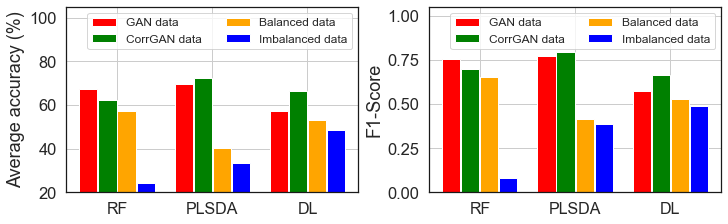

In [102]:
# Results
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.5):
        f, (axu, axd) = plt.subplots(1, 2, figsize=(10, 3), constrained_layout=True)
        x = np.arange(3)  # the label locations
        labels = ['RF', 'PLSDA', 'DL']
        width = 0.19  # the width of the bars
        
        offset = - 0.3 + 0 * 0.2
        accuracy_stats = pd.DataFrame({'Average accuracy': [RF_results['GAN data']['Accuracy']*100, 
                                                            PLSDA_results['GAN data']['Accuracy']*100,
                                                            dl_results['GAN data']*100]})
        rects = axu.bar(x + offset, accuracy_stats['Average accuracy'], width, label='GAN data', color='red')
        #axu.errorbar(x + offset, y=accuracy_stats['Average accuracy'], yerr=accuracy_stats['STD'],
        #                ls='none', ecolor='0.2', capsize=3)
        
        offset = - 0.3 + 1 * 0.2
        accuracy_stats = pd.DataFrame({'Average accuracy': [RF_results['CorrGAN data']['Accuracy']*100, 
                                                            PLSDA_results['CorrGAN data']['Accuracy']*100,
                                                            dl_results['CorrGAN data']*100]})
        rects = axu.bar(x + offset, accuracy_stats['Average accuracy'], width, label='CorrGAN data', color='green')
        #axu.errorbar(x + offset, y=accuracy_stats['Average accuracy'], yerr=accuracy_stats['STD'],
        #                ls='none', ecolor='0.2', capsize=3)
        
        offset = - 0.3 + 2 * 0.2
        accuracy_stats = pd.DataFrame({'Average accuracy': [RF_results['Balanced Set']['Accuracy']*100, 
                                                            PLSDA_results['Balanced Set']['Accuracy']*100,
                                                            dl_results['Balanced Set']*100]})
        rects = axu.bar(x + offset, accuracy_stats['Average accuracy'],
                        width, label='Balanced data', color='orange')
        #axu.errorbar(x + offset, y=accuracy_stats['Average accuracy'], yerr=accuracy_stats['STD'],
        #                ls='none', ecolor='0.2', capsize=3)
        
        offset = - 0.3 + 3 * 0.2
        accuracy_stats = pd.DataFrame({'Average accuracy': [RF_results['Imbalanced Set']['Accuracy']*100, 
                                                            PLSDA_results['Imbalanced Set']['Accuracy']*100,
                                                            dl_results['Imbalanced Set']*100]})
        rects = axu.bar(x + offset, accuracy_stats['Average accuracy'], width, label='Imbalanced data', color='blue')
        #axu.errorbar(x + offset, y=accuracy_stats['Average accuracy'], yerr=accuracy_stats['STD'],
         #               ls='none', ecolor='0.2', capsize=3)
        
        axu.set_xticks(x)
        axu.set_xticklabels(labels, fontsize=16)
        axu.set(ylabel='Average accuracy (%)', title='', ylim=(20,105))
        for spine in axu.spines.values():
            spine.set_edgecolor('0.1')
        
        axu.legend(loc='upper right', fontsize=12, ncol=2)
        
        
        offset = - 0.3 + 0 * 0.2
        accuracy_stats = pd.DataFrame({'Average accuracy': [RF_results['GAN data']['F1-Score'], 
                                                            PLSDA_results['GAN data']['F1-Score'],
                                                            dl_results['GAN data']]})
        rects = axd.bar(x + offset, accuracy_stats['Average accuracy'], width, label='GAN data', color='red')
        #axu.errorbar(x + offset, y=accuracy_stats['Average accuracy'], yerr=accuracy_stats['STD'],
        #                ls='none', ecolor='0.2', capsize=3)
        
        offset = - 0.3 + 1 * 0.2
        accuracy_stats = pd.DataFrame({'Average accuracy': [RF_results['CorrGAN data']['F1-Score'], 
                                                            PLSDA_results['CorrGAN data']['F1-Score'],
                                                            dl_results['CorrGAN data']]})
        rects = axd.bar(x + offset, accuracy_stats['Average accuracy'], width, label='CorrGAN data', color='green')
        #axu.errorbar(x + offset, y=accuracy_stats['Average accuracy'], yerr=accuracy_stats['STD'],
        #                ls='none', ecolor='0.2', capsize=3)
        
        offset = - 0.3 + 2 * 0.2
        accuracy_stats = pd.DataFrame({'Average accuracy': [RF_results['Balanced Set']['F1-Score'], 
                                                            PLSDA_results['Balanced Set']['F1-Score'],
                                                            dl_results['Balanced Set']]})
        rects = axd.bar(x + offset, accuracy_stats['Average accuracy'],
                        width, label='Balanced data', color='orange')
        #axu.errorbar(x + offset, y=accuracy_stats['Average accuracy'], yerr=accuracy_stats['STD'],
        #                ls='none', ecolor='0.2', capsize=3)
        
        offset = - 0.3 + 3 * 0.2
        accuracy_stats = pd.DataFrame({'Average accuracy': [RF_results['Imbalanced Set']['F1-Score'], 
                                                            PLSDA_results['Imbalanced Set']['F1-Score'],
                                                            dl_results['Imbalanced Set']]})
        rects = axd.bar(x + offset, accuracy_stats['Average accuracy'], width, label='Imbalanced data', color='blue')
        #axu.errorbar(x + offset, y=accuracy_stats['Average accuracy'], yerr=accuracy_stats['STD'],
         #               ls='none', ecolor='0.2', capsize=3)
        
        axd.set_xticks(x)
        axd.set_xticklabels(labels, fontsize=16)
        axd.set(ylabel='F1-Score', title='', ylim=(0,1.05))
        for spine in axd.spines.values():
            spine.set_edgecolor('0.1')
        
        axd.legend(loc='upper right', fontsize=12, ncol=2)
        #plt.title('Imbalanced Dataset Test', fontsize=17)
        plt.show()
        #f.savefig('images/HDimb_AccuPlot.png' , dpi=300)

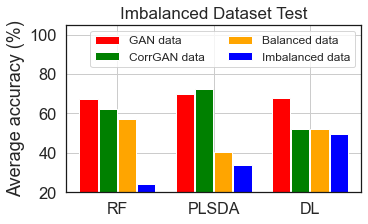

In [124]:
# Results
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.5):
        f, axu = plt.subplots(1, 1, figsize=(5, 3), constrained_layout=True)
        x = np.arange(3)  # the label locations
        labels = ['RF', 'PLSDA', 'DL']
        width = 0.19  # the width of the bars
        
        offset = - 0.3 + 0 * 0.2
        accuracy_stats = pd.DataFrame({'Average accuracy': [RF_results['GAN data']['Accuracy']*100, 
                                                            PLSDA_results['GAN data']['Accuracy']*100,
                                                            dl_results['GAN data']*100]})
        rects = axu.bar(x + offset, accuracy_stats['Average accuracy'], width, label='GAN data', color='red')
        #axu.errorbar(x + offset, y=accuracy_stats['Average accuracy'], yerr=accuracy_stats['STD'],
        #                ls='none', ecolor='0.2', capsize=3)
        
        offset = - 0.3 + 1 * 0.2
        accuracy_stats = pd.DataFrame({'Average accuracy': [RF_results['CorrGAN data']['Accuracy']*100, 
                                                            PLSDA_results['CorrGAN data']['Accuracy']*100,
                                                            dl_results['CorrGAN data']*100]})
        rects = axu.bar(x + offset, accuracy_stats['Average accuracy'], width, label='CorrGAN data', color='green')
        #axu.errorbar(x + offset, y=accuracy_stats['Average accuracy'], yerr=accuracy_stats['STD'],
        #                ls='none', ecolor='0.2', capsize=3)
        
        offset = - 0.3 + 2 * 0.2
        accuracy_stats = pd.DataFrame({'Average accuracy': [RF_results['Balanced Set']['Accuracy']*100, 
                                                            PLSDA_results['Balanced Set']['Accuracy']*100,
                                                            dl_results['Balanced Set']*100]})
        rects = axu.bar(x + offset, accuracy_stats['Average accuracy'],
                        width, label='Balanced data', color='orange')
        #axu.errorbar(x + offset, y=accuracy_stats['Average accuracy'], yerr=accuracy_stats['STD'],
        #                ls='none', ecolor='0.2', capsize=3)
        
        offset = - 0.3 + 3 * 0.2
        accuracy_stats = pd.DataFrame({'Average accuracy': [RF_results['Imbalanced Set']['Accuracy']*100, 
                                                            PLSDA_results['Imbalanced Set']['Accuracy']*100,
                                                            dl_results['Imbalanced Set']*100]})
        rects = axu.bar(x + offset, accuracy_stats['Average accuracy'], width, label='Imbalanced data', color='blue')
        #axu.errorbar(x + offset, y=accuracy_stats['Average accuracy'], yerr=accuracy_stats['STD'],
         #               ls='none', ecolor='0.2', capsize=3)
        
        axu.set_xticks(x)
        axu.set_xticklabels(labels, fontsize=16)
        axu.set(ylabel='Average accuracy (%)', title='', ylim=(20,105))
        for spine in axu.spines.values():
            spine.set_edgecolor('0.1')
        
        axu.legend(loc='upper right', fontsize=12, ncol=2)

        plt.title('Imbalanced Dataset Test', fontsize=17)
        plt.show()
        f.savefig('images/HDimb_AccuPlot.png' , dpi=300)

PLS-DA projections

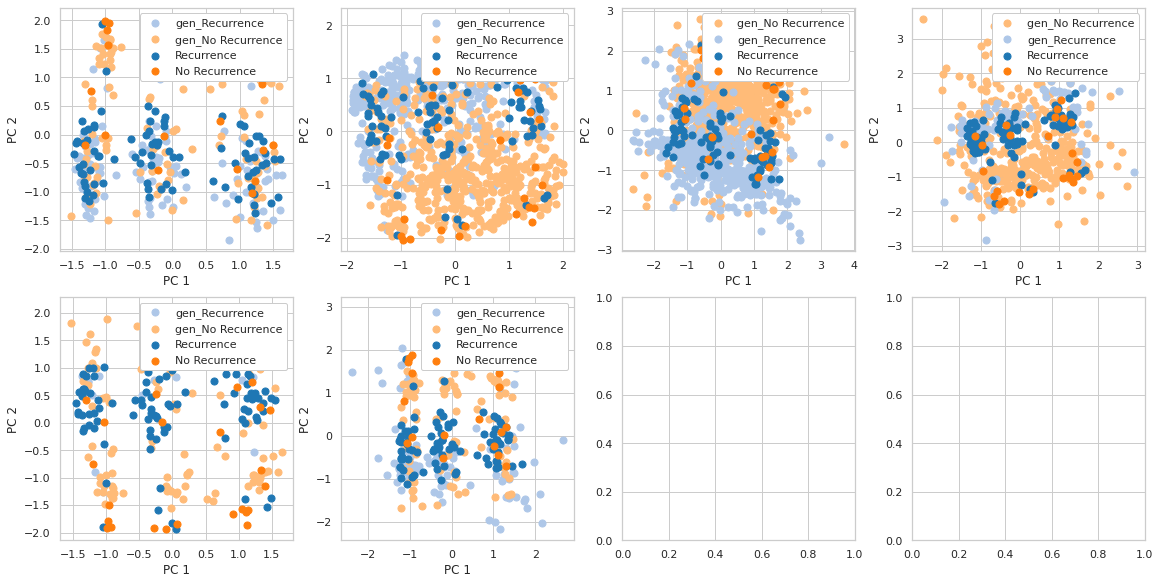

In [203]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1):
        f, axs = plt.subplots(2,4, figsize=(16,8), constrained_layout=True)
        
        for i, ax in zip(dfs.keys(), axs.ravel()):
            dfs_temp = pd.concat((dfs[i], r_data))
            temp_lbls = ['gen_' + l for l in dfs_lbl[i]].copy() + test_data_labels
            
            principaldf = ma.compute_df_with_PCs(dfs_temp, n_components=2, whiten=True, labels=temp_lbls,
                                                 return_var_ratios=False)

            lcolors = label_colors_test
            
            gem.plot_PCA(principaldf, lcolors, components=(1,2), title='', ax=ax)
            #gem.plot_ellipses_PCA(principaldf, lcolors, components=(1,2),ax=ax, q=0.95)
            ax.legend(loc='upper right', ncol=1, framealpha=1)
        

C:\Users\franc\AppData\Local\Temp\ipykernel_2680\3626387764.py:13: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


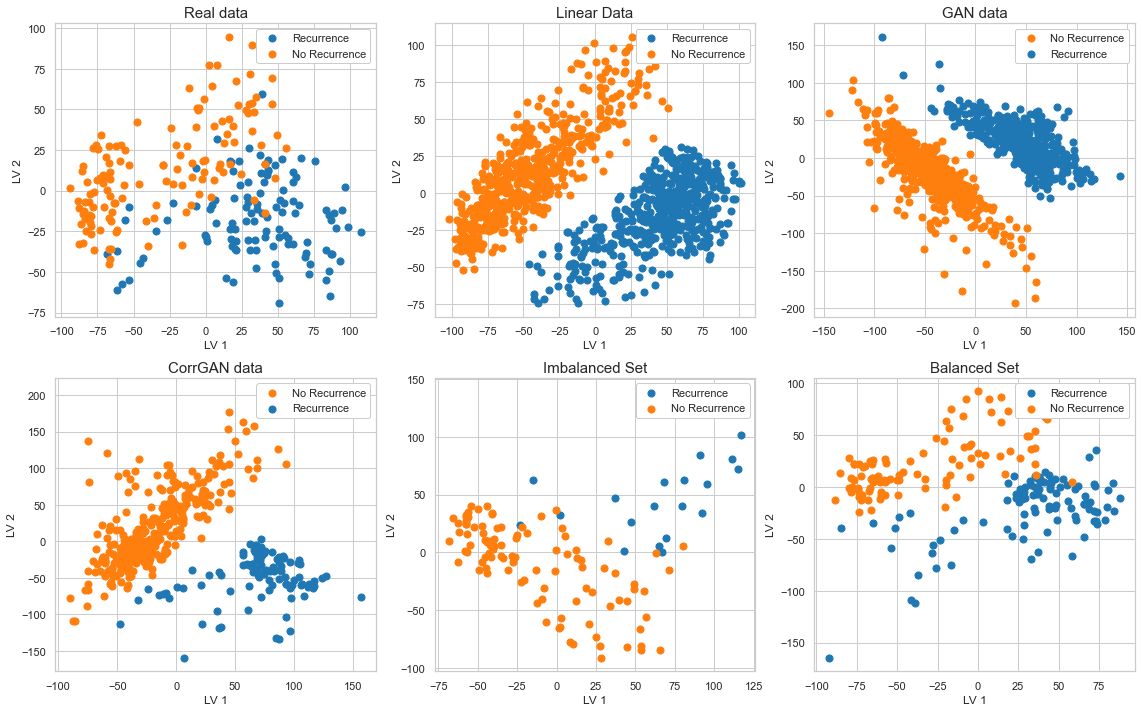

In [158]:
n_components = 4
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1):
        f, axs = plt.subplots(2,3, figsize=(16,10), constrained_layout=True)
        
        for i, ax in zip(dfs.keys(), axs.ravel()):
            model, scores = ma.fit_PLSDA_model(dfs[i], dfs_lbl[i], n_comp=n_components)
            lcolors = label_colors_test
            
            gem.plot_PLS(scores, lcolors, title=i, ax=ax)
            #gem.plot_ellipses_PCA(principaldf, lcolors, components=(1,2),ax=ax, q=0.95)
            ax.legend(loc='upper right', ncol=1, framealpha=1)
    plt.tight_layout()
    plt.show()

C:\Users\franc\AppData\Local\Temp\ipykernel_2680\2038449825.py:16: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


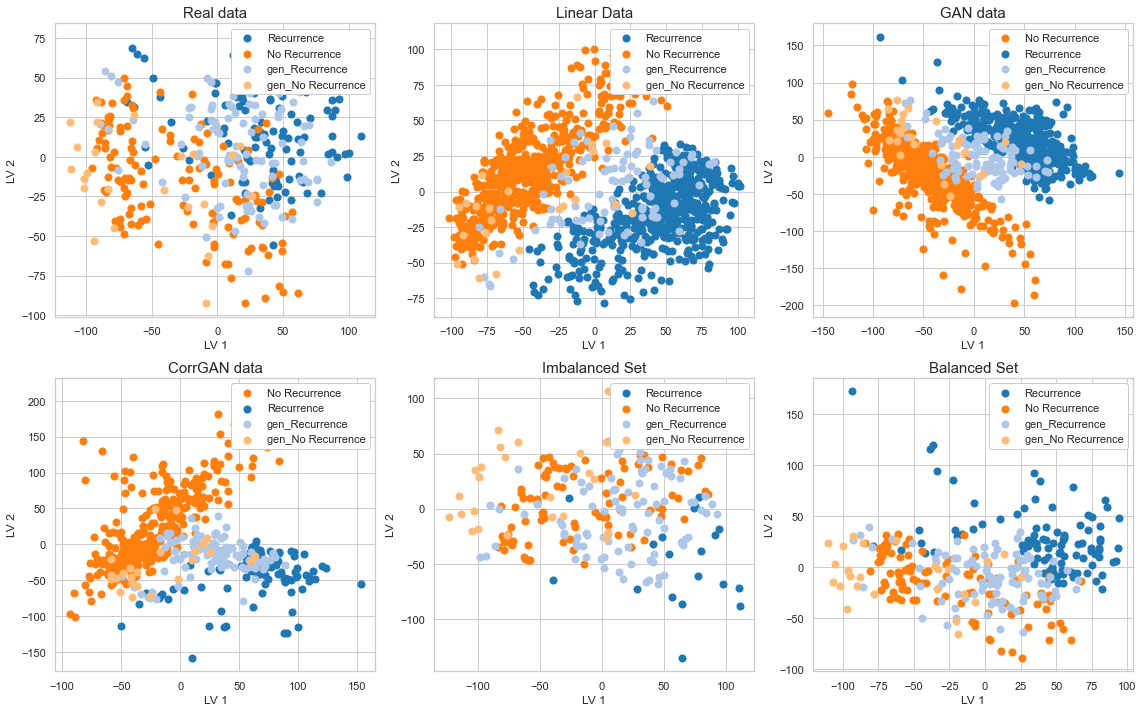

In [159]:
r_labels = test_data_labels
n_components = 4
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1):
        f, axs = plt.subplots(2,3, figsize=(16,10), constrained_layout=True)
        
        for i, ax in zip(dfs.keys(), axs.ravel()):
            df_temp = pd.concat((dfs[i], r_data))
            lbl_temp = dfs_lbl[i] + ['gen_' + i for i in r_labels]
            model, scores = ma.fit_PLSDA_model(df_temp, lbl_temp, n_comp=n_components)
            lcolors = label_colors_test
            
            gem.plot_PLS(scores, lcolors, title=i, ax=ax)
            #gem.plot_ellipses_PCA(principaldf, lcolors, components=(1,2),ax=ax, q=0.95)
            ax.legend(loc='upper right', ncol=1, framealpha=1)
    plt.tight_layout()
    plt.show()

C:\Users\franc\AppData\Local\Temp\ipykernel_21924\2038449825.py:16: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


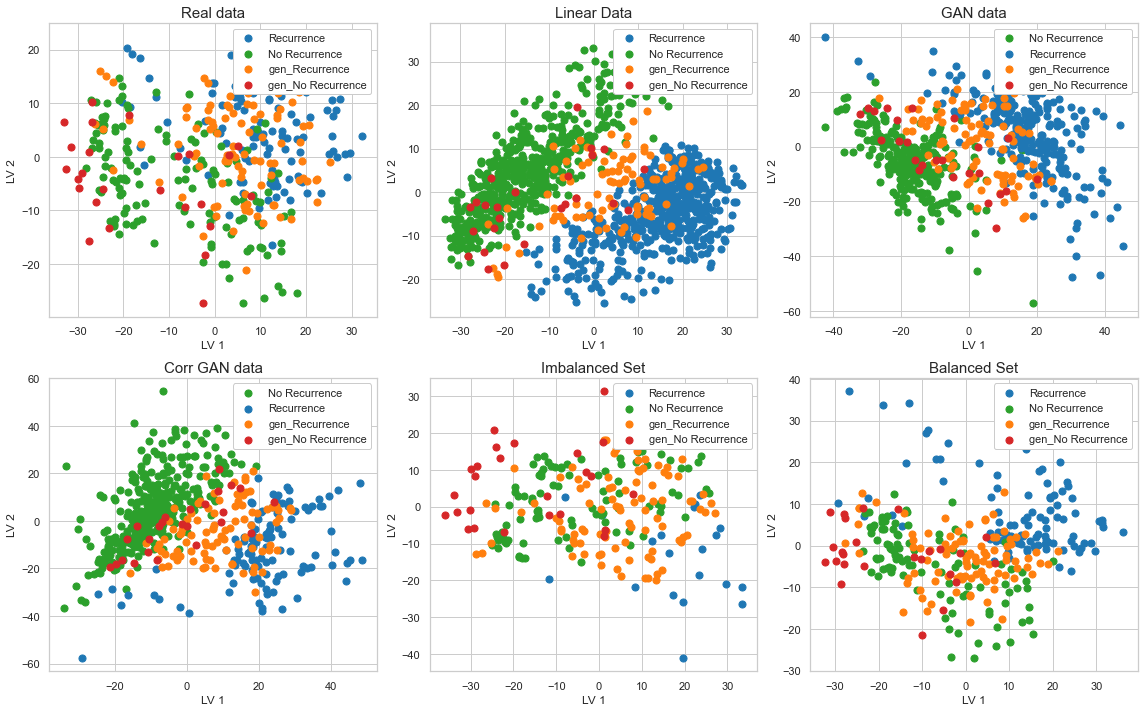

In [129]:
r_labels = test_data_labels
n_components = 4
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1):
        f, axs = plt.subplots(2,3, figsize=(16,10), constrained_layout=True)
        
        for i, ax in zip(dfs.keys(), axs.ravel()):
            df_temp = pd.concat((dfs[i], r_data))
            lbl_temp = dfs_lbl[i] + ['gen_' + i for i in r_labels]
            model, scores = ma.fit_PLSDA_model(df_temp, lbl_temp, n_comp=n_components)
            lcolors = label_colors_test
            
            gem.plot_PLS(scores, lcolors, title=i, ax=ax)
            #gem.plot_ellipses_PCA(principaldf, lcolors, components=(1,2),ax=ax, q=0.95)
            ax.legend(loc='upper right', ncol=1, framealpha=1)
    plt.tight_layout()
    plt.show()

### Comparing Important Features

See models built with the a lot of GAN generated data and the real data and compare the important features selected by both (values and identities).

In [131]:
num_examples_to_generate = 2048
test_input = tf.constant(input_realdata_dist.rvs(size=len(human_datamatrix.columns)*num_examples_to_generate
                                                ), shape=[num_examples_to_generate,len(human_datamatrix.columns)])
test_labels = tf.constant([1]*(num_examples_to_generate//2) + [0]*(num_examples_to_generate//2), shape=[
        num_examples_to_generate,1])
predictions = generator([test_input, test_labels], training=False)

In [132]:
predictions = pd.DataFrame(predictions.numpy(), columns=human_datamatrix.columns)

#### RF

Feature Importance judged by Gini Importance

In [169]:
np.random.seed(137532)
RF_model_GANdata = ma.RF_model(predictions, dfs_lbl['GAN data'], return_cv=False, n_trees=200)
RF_model_REALdata = ma.RF_model(human_datamatrix_treated, hd_labels, return_cv=False, n_trees=200)
RF_model_CORRdata = ma.RF_model(corr_preds, corr_lbls, return_cv=False, n_trees=200)

In [170]:
RF_model_GANdata.feature_importances_

array([0.        , 0.00193119, 0.        , ..., 0.        , 0.        ,
       0.        ])

In [171]:
# Extract and order important features
rf_GAN_feats = zip(range(1, len(human_datamatrix_treated.columns)+1), RF_model_GANdata.feature_importances_)
rf_real_feats = zip(range(1, len(human_datamatrix_treated.columns)+1), RF_model_REALdata.feature_importances_)
rf_corr_feats = zip(range(1, len(human_datamatrix_treated.columns)+1), RF_model_CORRdata.feature_importances_)

rf_GAN_df = pd.DataFrame(rf_GAN_feats)
rf_real_df = pd.DataFrame(rf_real_feats)
rf_corr_df = pd.DataFrame(rf_corr_feats)

In [172]:
# Sorting from most to least important feature
sorted_GAN_feats = rf_GAN_df.set_index(0).sort_values(by=1, ascending=False)
sorted_GAN_feats

,1
0,
1166,0.014228
4278,0.012978
845,0.012683
4543,0.012473
4211,0.010939
...,...
4740,0.000000
4741,0.000000
4742,0.000000


In [173]:
# Sorting from most to least important feature
sorted_real_feats = rf_real_df.set_index(0).sort_values(by=1, ascending=False)
sorted_corr_feats = rf_corr_df.set_index(0).sort_values(by=1, ascending=False)
sorted_real_feats

,1
0,
4286,0.015956
4543,0.010803
9162,0.008813
4287,0.007715
4558,0.007295
...,...
4524,0.000000
4526,0.000000
4527,0.000000


In [174]:
# See intersections between important features of models generated with GAN or Experimental Data
intersections = []
for i in range(1, len(sorted_GAN_feats)):
    intersections.append(len(np.intersect1d(sorted_GAN_feats.index[:i], sorted_real_feats.index[:i])))

# See intersections between important features of models generated with CorrGAN or Experimental Data
intersections_corr= []
for i in range(1, len(sorted_corr_feats)):
    intersections_corr.append(len(np.intersect1d(sorted_corr_feats.index[:i], sorted_real_feats.index[:i])))    

# See intersections if features were randomly shuffled
random_intersections = []
copy_shuffle = list(sorted_real_feats.index).copy()
np.random.shuffle(copy_shuffle)
for i in range(1, len(sorted_GAN_feats)):
    random_intersections.append(len(np.intersect1d(sorted_GAN_feats.index[:i], copy_shuffle[:i])))

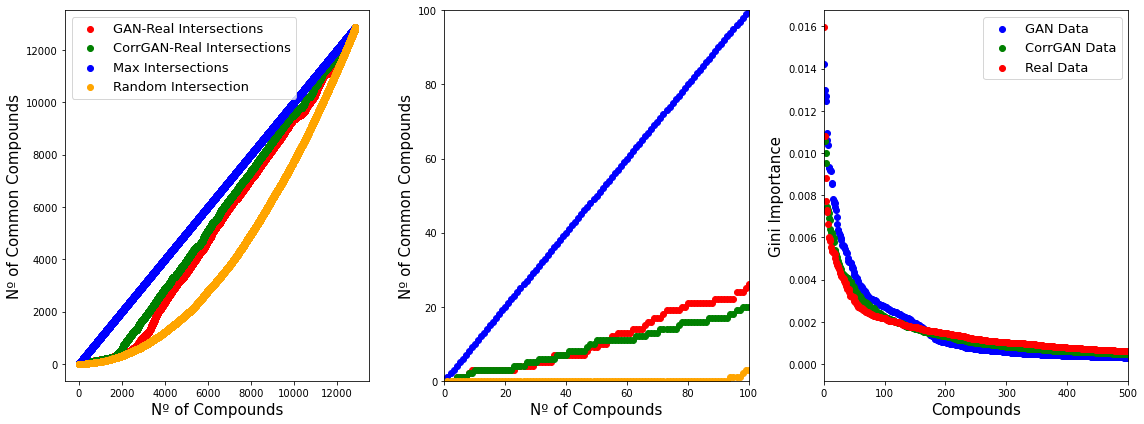

In [176]:
f, (axl, axc, axr) = plt.subplots(1,3,figsize=(16,6))
# Graph depicting intersection of important features
axl.scatter(range(1,len(sorted_GAN_feats)), intersections, label = 'GAN-Real Intersections', color='Red')
axl.scatter(range(1,len(sorted_GAN_feats)), intersections_corr, label = 'CorrGAN-Real Intersections', color='Green')
axl.scatter(range(1,len(sorted_GAN_feats)), range(1,len(sorted_GAN_feats)), label = 'Max Intersections', color='Blue')
axl.scatter(range(1,len(sorted_GAN_feats)), random_intersections, label = 'Random Intersection', color='Orange')
axl.legend(loc='upper left', fontsize=13)
axl.set_xlabel('Nº of Compounds', fontsize=15)
axl.set_ylabel('Nº of Common Compounds', fontsize=15)

# Graph depicting intersection of important features with focus on the most important features
axc.scatter(range(1,len(sorted_GAN_feats)), intersections, label = 'GAN-Real Intersections', color='Red')
axc.scatter(range(1,len(sorted_GAN_feats)), intersections_corr, label = 'CorrGAN-Real Intersections', color='Green')
axc.scatter(range(1,len(sorted_GAN_feats)), range(1,len(sorted_GAN_feats)), label = 'Max Intersections', color='Blue')
axc.scatter(range(1,len(sorted_GAN_feats)), random_intersections, label = 'Random Intersection', color='Orange')
axc.set_xlim([0,100])
axc.set_ylim([0,100])
axc.set_xlabel('Nº of Compounds', fontsize=15)
axc.set_ylabel('Nº of Common Compounds', fontsize=15)

# Values of Gini Importance for RF models from GAN and Real Data
axr.scatter(range(1,len(rf_GAN_df)+1), rf_GAN_df.set_index(0).sort_values(by=1, ascending=False), 
            color='blue', label='GAN Data')
axr.scatter(range(1,len(rf_corr_df)+1), rf_corr_df.set_index(0).sort_values(by=1, ascending=False), 
            color='green', label='CorrGAN Data')
axr.scatter(range(1,len(rf_real_df)+1), rf_real_df.set_index(0).sort_values(by=1, ascending=False), 
            color='red', label='Real Data')
axr.legend(fontsize=13)
axr.set_xlim([0,500])
axr.set_xlabel('Compounds', fontsize=15)
axr.set_ylabel('Gini Importance', fontsize=15)

plt.tight_layout()
plt.show()

#### PLS-DA

Feature Importance judged by VIP (Variable Importance in Projection)

In [178]:
# Fit the PLS-DA model
np.random.seed(137532)
PLSDA_model_GANdata = ma.fit_PLSDA_model(predictions, dfs_lbl['GAN data'], n_comp=7, return_scores=False,
                    scale=False, encode2as1vector=True) 
PLSDA_model_REALdata = ma.fit_PLSDA_model(human_datamatrix_treated, hd_labels, 
                                          n_comp=7, return_scores=False, scale=False, encode2as1vector=True)
PLSDA_model_CORRdata = ma.fit_PLSDA_model(corr_preds, corr_lbls, 
                                          n_comp=7, return_scores=False, scale=False, encode2as1vector=True)

In [180]:
# Extract and order important features
plsda_GAN_feats = zip(range(1, len(human_datamatrix_treated.columns)+1), ma._calculate_vips(PLSDA_model_GANdata))
plsda_real_feats = zip(range(1, len(human_datamatrix_treated.columns)+1), ma._calculate_vips(PLSDA_model_REALdata))
plsda_corr_feats = zip(range(1, len(human_datamatrix_treated.columns)+1), ma._calculate_vips(PLSDA_model_CORRdata))

plsda_GAN_df = pd.DataFrame(plsda_GAN_feats)
plsda_real_df = pd.DataFrame(plsda_real_feats)
plsda_corr_df = pd.DataFrame(plsda_corr_feats)

In [181]:
# Sorting from most to least important feature
sorted_GAN_feats = plsda_GAN_df.set_index(0).sort_values(by=1, ascending=False)
sorted_real_feats = plsda_real_df.set_index(0).sort_values(by=1, ascending=False)
sorted_corr_feats = plsda_corr_df.set_index(0).sort_values(by=1, ascending=False)

In [182]:
# See intersections between important features of models generated with GAN or Experimental Data
intersections = []
for i in range(1, len(sorted_GAN_feats)):
    intersections.append(len(np.intersect1d(sorted_GAN_feats.index[:i], sorted_real_feats.index[:i])))

intersections_corr = []
for i in range(1, len(sorted_corr_feats)):
    intersections_corr.append(len(np.intersect1d(sorted_corr_feats.index[:i], sorted_real_feats.index[:i])))

# See intersections if features were randomly shuffled  
random_intersections = []
copy_shuffle = list(sorted_real_feats.index).copy()
np.random.shuffle(copy_shuffle)
for i in range(1, len(sorted_GAN_feats)):
    random_intersections.append(len(np.intersect1d(sorted_GAN_feats.index[:i], copy_shuffle[:i])))

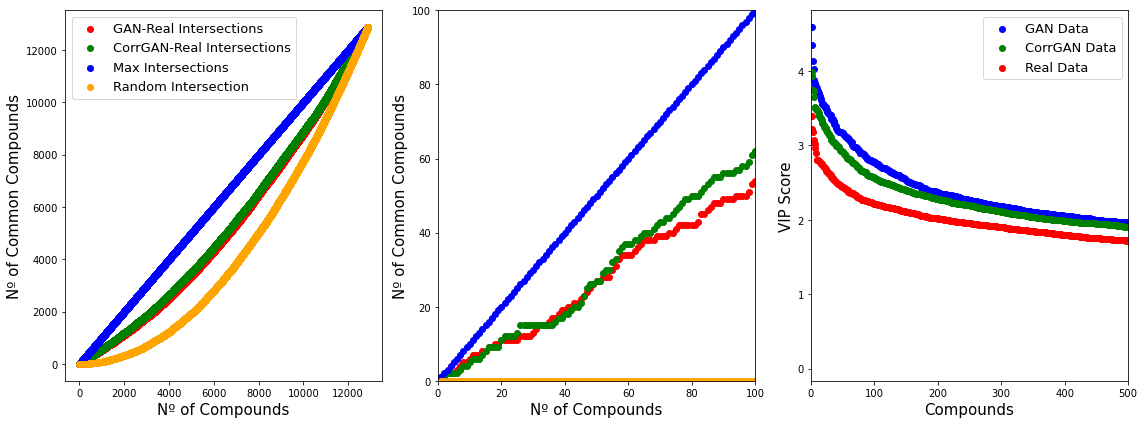

In [183]:
f, (axl, axc, axr) = plt.subplots(1,3,figsize=(16,6))
# Graph depicting intersection of important features
axl.scatter(range(1,len(sorted_GAN_feats)), intersections, label = 'GAN-Real Intersections', color='Red')
axl.scatter(range(1,len(sorted_GAN_feats)), intersections_corr, label = 'CorrGAN-Real Intersections', color='Green')
axl.scatter(range(1,len(sorted_GAN_feats)), range(1,len(sorted_GAN_feats)), label = 'Max Intersections', color='Blue')
axl.scatter(range(1,len(sorted_GAN_feats)), random_intersections, label = 'Random Intersection', color='Orange')
axl.legend(loc='upper left', fontsize=13)
axl.set_xlabel('Nº of Compounds', fontsize=15)
axl.set_ylabel('Nº of Common Compounds', fontsize=15)

# Graph depicting intersection of important features with focus on the most important features
axc.scatter(range(1,len(sorted_GAN_feats)), intersections, label = 'GAN-Real Intersections', color='Red')
axc.scatter(range(1,len(sorted_GAN_feats)), intersections_corr, label = 'CorrGAN-Real Intersections', color='Green')
axc.scatter(range(1,len(sorted_GAN_feats)), range(1,len(sorted_GAN_feats)), label = 'Max Intersections', color='Blue')
axc.scatter(range(1,len(sorted_GAN_feats)), random_intersections, label = 'Random Intersection', color='Orange')
axc.set_xlim([0,100])
axc.set_ylim([0,100])
axc.set_xlabel('Nº of Compounds', fontsize=15)
axc.set_ylabel('Nº of Common Compounds', fontsize=15)

# Values of VIP Score for PLS-DA models from GAN and Real Data
axr.scatter(range(1,len(plsda_GAN_df)+1), plsda_GAN_df.set_index(0).sort_values(by=1, ascending=False), 
            color='blue', label='GAN Data')
axr.scatter(range(1,len(plsda_corr_df)+1), plsda_corr_df.set_index(0).sort_values(by=1, ascending=False), 
            color='green', label='CorrGAN Data')
axr.scatter(range(1,len(plsda_real_df)+1), plsda_real_df.set_index(0).sort_values(by=1, ascending=False), 
            color='red', label='Real Data')
axr.legend(fontsize=13)
axr.set_xlim([0,500])
axr.set_xlabel('Compounds', fontsize=15)
axr.set_ylabel('VIP Score', fontsize=15)

plt.tight_layout()
plt.show()

Deep Learning Tests

In [187]:
def deep_classifier(len_input, n_labels):
    "Function to build a deep learning classifier."
    classifier = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation=tf.nn.leaky_relu, use_bias=True, input_shape=(len_input,)),
        tf.keras.layers.Dense(512, activation=tf.nn.leaky_relu, use_bias=True),
        tf.keras.layers.Dense(128, activation=tf.nn.leaky_relu, use_bias=True),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(n_labels, activation='softmax', use_bias=True)]) # Nº of nodes equals number of classes
    
    classifier.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return classifier

In [201]:
# To store loss and accuracies of deep learning model
dl_loss = {}
dl_losstest = {}
dl_results = {}

r_data = test_datamatrix_treated#/(2*test_datamatrix_treated.values.std())
#r_labels = ma._generate_y_PLSDA(test_data_labels, list(pd.unique(dfs_lbl[name])), True)

for i in dfs:
    print(i)
    deep_class = deep_classifier(len(dfs[i].columns), len(set(dfs_lbl[i])))
    model = deep_class.fit(dfs[i].values, 
                           pd.get_dummies(dfs_lbl[i])[['Recurrence', 'No Recurrence']], epochs = 100, 
                           batch_size=32,
                           validation_data=(r_data.values, 
                                            pd.get_dummies(test_data_labels)[['Recurrence', 'No Recurrence']]))
    # Store Results
    dl_loss[i] = model.history['loss']
    dl_losstest[i], dl_results[i] = deep_class.evaluate(r_data.values,
                                                        pd.get_dummies(test_data_labels)[['Recurrence', 'No Recurrence']])


Real data
Epoch 1/100
8/8 [==============================] - 1s 95ms/step - loss: 0.8054 - accuracy: 0.6867 - val_loss: 1.5210 - val_accuracy: 0.7479
Epoch 2/100
8/8 [==============================] - 0s 32ms/step - loss: 0.2810 - accuracy: 0.8916 - val_loss: 0.3842 - val_accuracy: 0.8908
Epoch 3/100
8/8 [==============================] - 0s 19ms/step - loss: 0.1388 - accuracy: 0.9317 - val_loss: 0.0465 - val_accuracy: 0.9832
Epoch 4/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0739 - accuracy: 0.9719 - val_loss: 0.0858 - val_accuracy: 0.9748
Epoch 5/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0236 - accuracy: 0.9960 - val_loss: 0.1360 - val_accuracy: 0.9328
Epoch 6/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0073 - accuracy: 1.0000 - val_loss: 0.0725 - val_accuracy: 0.9580
Epoch 7/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0090 - accuracy: 1.0000 - val_loss: 0.0577 - val_accuracy: 0.9916
Epoch 8/10

32/32 [==============================] - 0s 6ms/step - loss: 9.9525e-05 - accuracy: 1.0000 - val_loss: 1.7408 - val_accuracy: 0.6639
Epoch 15/100
32/32 [==============================] - 0s 6ms/step - loss: 5.0744e-05 - accuracy: 1.0000 - val_loss: 1.7553 - val_accuracy: 0.6639
Epoch 16/100
32/32 [==============================] - 0s 5ms/step - loss: 8.9314e-05 - accuracy: 1.0000 - val_loss: 1.7688 - val_accuracy: 0.6639
Epoch 17/100
32/32 [==============================] - 0s 6ms/step - loss: 5.3356e-05 - accuracy: 1.0000 - val_loss: 1.7934 - val_accuracy: 0.6639
Epoch 18/100
32/32 [==============================] - 0s 6ms/step - loss: 5.8228e-05 - accuracy: 1.0000 - val_loss: 1.8045 - val_accuracy: 0.6639
Epoch 19/100
32/32 [==============================] - 0s 6ms/step - loss: 7.2334e-05 - accuracy: 1.0000 - val_loss: 1.8037 - val_accuracy: 0.6639
Epoch 20/100
32/32 [==============================] - 0s 6ms/step - loss: 1.0548e-04 - accuracy: 1.0000 - val_loss: 1.8165 - val_accuracy

Epoch 26/100
32/32 [==============================] - 0s 7ms/step - loss: 3.8314e-05 - accuracy: 1.0000 - val_loss: 1.8693 - val_accuracy: 0.6050
Epoch 27/100
32/32 [==============================] - 0s 6ms/step - loss: 8.5689e-05 - accuracy: 1.0000 - val_loss: 1.8626 - val_accuracy: 0.5966
Epoch 28/100
32/32 [==============================] - 0s 6ms/step - loss: 2.6546e-05 - accuracy: 1.0000 - val_loss: 1.8738 - val_accuracy: 0.5966
Epoch 29/100
32/32 [==============================] - 0s 6ms/step - loss: 1.4397e-05 - accuracy: 1.0000 - val_loss: 1.8989 - val_accuracy: 0.5966
Epoch 30/100
32/32 [==============================] - 0s 9ms/step - loss: 5.0459e-05 - accuracy: 1.0000 - val_loss: 1.9368 - val_accuracy: 0.5966
Epoch 31/100
32/32 [==============================] - 0s 8ms/step - loss: 5.1024e-05 - accuracy: 1.0000 - val_loss: 1.9279 - val_accuracy: 0.5966
Epoch 32/100
32/32 [==============================] - 0s 6ms/step - loss: 1.2439e-04 - accuracy: 1.0000 - val_loss: 1.8151 -

15/15 [==============================] - 0s 11ms/step - loss: 0.0175 - accuracy: 0.9978 - val_loss: 2.6130 - val_accuracy: 0.5210
Epoch 39/100
15/15 [==============================] - 0s 12ms/step - loss: 0.0241 - accuracy: 0.9870 - val_loss: 2.8928 - val_accuracy: 0.5378
Epoch 40/100
15/15 [==============================] - 0s 11ms/step - loss: 0.0161 - accuracy: 0.9978 - val_loss: 2.6964 - val_accuracy: 0.6050
Epoch 41/100
15/15 [==============================] - 0s 11ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 2.4828 - val_accuracy: 0.5882
Epoch 42/100
15/15 [==============================] - 0s 10ms/step - loss: 0.0058 - accuracy: 0.9957 - val_loss: 2.3970 - val_accuracy: 0.6134
Epoch 43/100
15/15 [==============================] - 0s 11ms/step - loss: 3.5799e-04 - accuracy: 1.0000 - val_loss: 2.4906 - val_accuracy: 0.5882
Epoch 44/100
15/15 [==============================] - 0s 10ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 2.5117 - val_accuracy: 0.5882
Epoch 45

Epoch 95/100
15/15 [==============================] - 0s 8ms/step - loss: 5.2415e-05 - accuracy: 1.0000 - val_loss: 2.9264 - val_accuracy: 0.5462
Epoch 96/100
15/15 [==============================] - 0s 12ms/step - loss: 4.7121e-05 - accuracy: 1.0000 - val_loss: 2.9496 - val_accuracy: 0.5462
Epoch 97/100
15/15 [==============================] - 0s 8ms/step - loss: 4.3808e-05 - accuracy: 1.0000 - val_loss: 2.9555 - val_accuracy: 0.5462
Epoch 98/100
15/15 [==============================] - 0s 7ms/step - loss: 7.8232e-05 - accuracy: 1.0000 - val_loss: 2.9693 - val_accuracy: 0.5462
Epoch 99/100
15/15 [==============================] - 0s 7ms/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 2.9280 - val_accuracy: 0.5546
Epoch 100/100
4/4 [==============================] - 0s 3ms/step - loss: 2.8190 - accuracy: 0.5630
Imbalanced Set
Epoch 1/100
4/4 [==============================] - 1s 55ms/step - loss: 1.3983 - accuracy: 0.5833 - val_loss: 2.7125 - val_accuracy: 0.6723
Epoch 2/100
4/4 [==

7/7 [==============================] - 0s 19ms/step - loss: 0.0071 - accuracy: 1.0000 - val_loss: 1.4432 - val_accuracy: 0.6471
Epoch 10/100
7/7 [==============================] - 0s 18ms/step - loss: 0.0061 - accuracy: 1.0000 - val_loss: 1.5392 - val_accuracy: 0.6387
Epoch 11/100
7/7 [==============================] - 0s 10ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 1.6374 - val_accuracy: 0.6050
Epoch 12/100
7/7 [==============================] - 0s 10ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 1.7026 - val_accuracy: 0.6134
Epoch 13/100
7/7 [==============================] - 0s 10ms/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 1.7481 - val_accuracy: 0.6134
Epoch 14/100
7/7 [==============================] - 0s 10ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 1.7991 - val_accuracy: 0.5798
Epoch 15/100
7/7 [==============================] - 0s 9ms/step - loss: 0.0171 - accuracy: 0.9950 - val_loss: 2.1226 - val_accuracy: 0.5378
Epoch 16/100
7/7 [=========

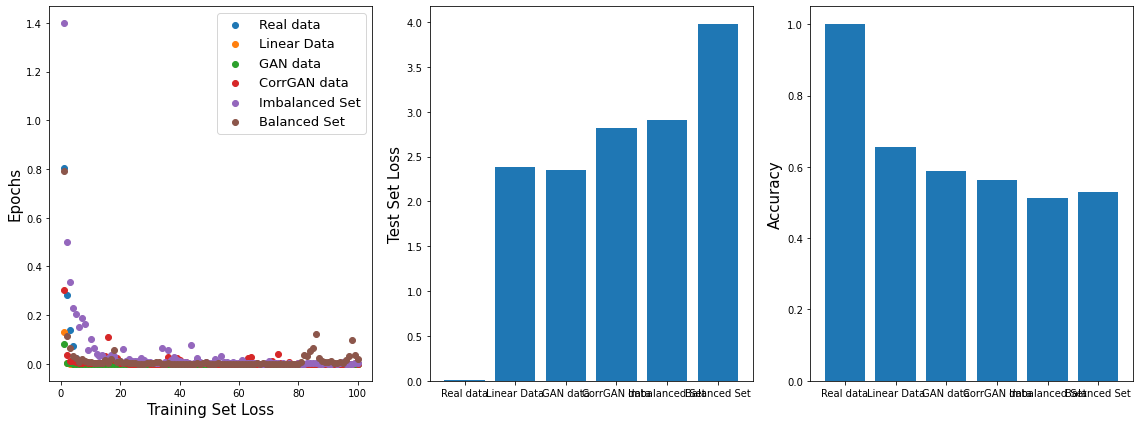

In [202]:
f, (axl, axc, axr) = plt.subplots(1,3,figsize=(16,6))
epochs=100
# Graph depicting deep learning model Loss
for i in dl_loss.keys():
    axl.scatter(range(1,epochs+1), dl_loss[i], label=i)
axl.legend(loc='upper right', fontsize=13)
axl.set_xlabel('Training Set Loss', fontsize=15)
axl.set_ylabel('Epochs', fontsize=15)

# Graph depicting deep learning model Loss of the test set
axc.bar(dl_losstest.keys(),
    list(dl_losstest.values()))
axc.set_ylabel('Test Set Loss', fontsize=15)

# Deep Learning model accuracy on predicting the test set class
axr.bar(dl_results.keys(),
    list(dl_results.values()))
axr.set_ylabel('Accuracy', fontsize=15)

plt.tight_layout()
plt.show()